In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install -r /content/drive/MyDrive/requirements.txt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 21.8 MB/s eta 0:00:00


# Imports

In [3]:
#import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import os
import wfdb
from scipy import signal
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
#from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import neurokit2 as nk
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import butter, lfilter, freqz, iirnotch

import tensorflow as tf
from tensorflow.keras import layers

# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.expand_frame_repr', False)  # Disable wrapping
# pd.set_option('display.max_colwidth', None)  # Show full contents of each cell

pd.reset_option('display.max_columns')  # Show all columns
pd.reset_option('display.expand_frame_repr')  # Disable wrapping
pd.reset_option('display.max_colwidth')  # Show full contents of each cell


# Load data


In [4]:
# import os
# import pandas as pd
# import wfdb

# # Load the CSV file
# subclass_df = pd.read_csv('subclass.csv')

# # Initialize empty arrays to store the data
# data = []

# # Specify the root directory
# root_dir = '../ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'

# # Loop over all records in the DataFrame
# for idx, row in subclass_df.iterrows():
#     if (idx+1)%100 == 0:
#         print(f"Processing record {idx+1}/{len(subclass_df)}")
#     # Get filename without extension
#     filename = os.path.splitext(row['filename_lr'])[0]

#     # Construct the full path
#     full_path = os.path.join(root_dir, filename)

#     # Load the raw ECG signal data from the .dat file
#     dat, fields = wfdb.rdsamp(full_path)

#     # Load the labels data from the .hea file
#     hea = wfdb.rdheader(full_path)

#     # Add data to the list
#     data.append({
#         'record_name': filename,
#         'subclass': row['diagnostic_subclass'],
#         'signal': dat,
#         'age': row['age'],
#         'sex': row['sex']
#     })

# # Convert the list to a DataFrame
# df = pd.DataFrame(data)

# # Save the DataFrame
# df.to_pickle('df_processed_sub.pkl')

df_orig = pd.read_pickle('/content/drive/MyDrive/nico/df_processed_sub.pkl')
df_orig

,record_name,subclass,signal,age,sex
0,records100/00000/00001_lr,['NORM'],"[[-0.119, -0.055, 0.064, 0.086, -0.091, 0.004,...",56.0,1
1,records100/00000/00002_lr,['NORM'],"[[0.004, 0.138, 0.134, -0.072, -0.065, 0.136, ...",19.0,0
2,records100/00000/00003_lr,['NORM'],"[[-0.029, -0.079, -0.049, 0.054, 0.011, -0.064...",37.0,1
3,records100/00000/00004_lr,['NORM'],"[[-0.054, -0.138, -0.083, 0.096, 0.015, -0.11,...",24.0,0
4,records100/00000/00005_lr,['NORM'],"[[-0.034, -0.574, -0.54, 0.304, 0.253, -0.556,...",19.0,1
...,...,...,...,...,...
15206,records100/21000/21833_lr,['STTC'],"[[-0.052, -0.034, 0.018, 0.043, -0.034, -0.008...",67.0,1
15207,records100/21000/21834_lr,['NORM'],"[[-0.05, -0.013, 0.036, 0.031, -0.042, 0.011, ...",300.0,0
15208,records100/21000/21835_lr,['ISCA'],"[[0.038, 0.024, -0.014, -0.03, 0.026, 0.005, 0...",59.0,1
15209,records100/21000/21836_lr,['NORM'],"[[-0.057, -0.057, 0.0, 0.057, -0.028, -0.028, ...",64.0,1


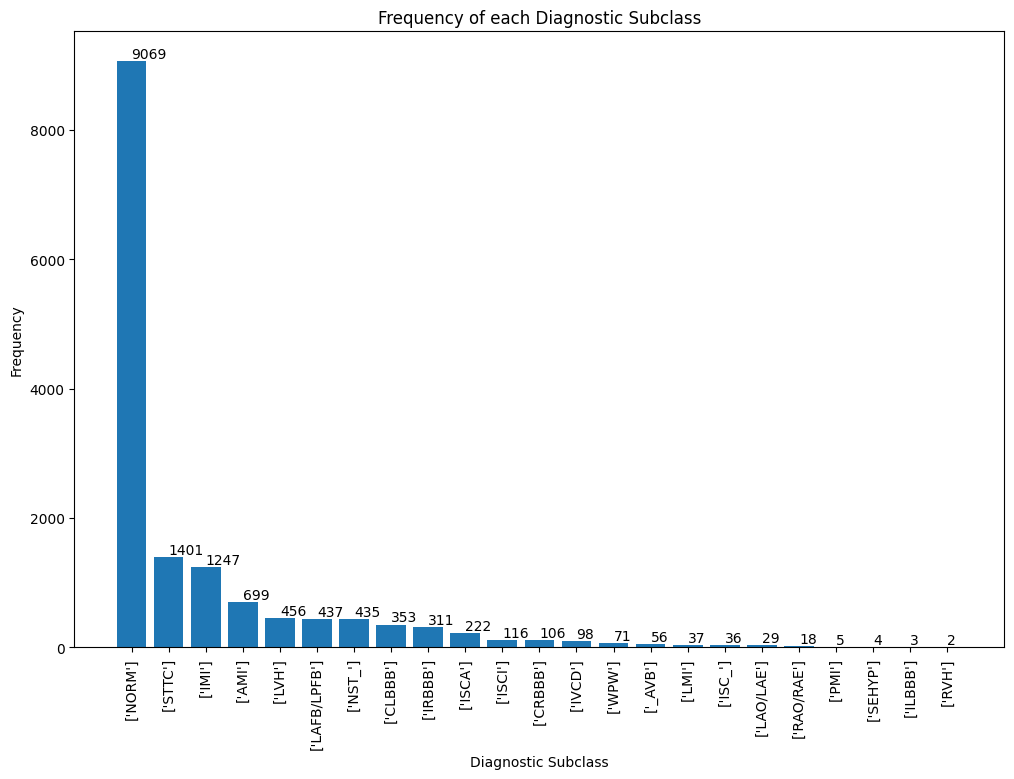

In [5]:
import matplotlib.pyplot as plt

# Convert any list-like objects in 'subclass' to strings
df_orig['subclass'] = df_orig['subclass'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

# Count the number of occurrences of each element in 'subclass'
subclass_counts = df_orig['subclass'].value_counts()

# Plot the frequency of each subclass
plt.figure(figsize=(12,8))
bars = plt.bar(subclass_counts.index, subclass_counts.values)
plt.title('Frequency of each Diagnostic Subclass')
plt.xlabel('Diagnostic Subclass')
plt.ylabel('Frequency')
plt.xticks(rotation='vertical')

# Add count annotations above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom')  # va: vertical alignment

plt.show()


In [6]:
# Number of records to remove
n = 7000

# Get indices of 'NORM' class
norm_indices = df_orig[df_orig['subclass'] == '[\'NORM\']'].index

# Randomly select n indices
random_indices = np.random.choice(norm_indices, n, replace=False)

# Drop these rows
df_orig = df_orig.drop(random_indices)
df_orig = df_orig.reset_index(drop=True)




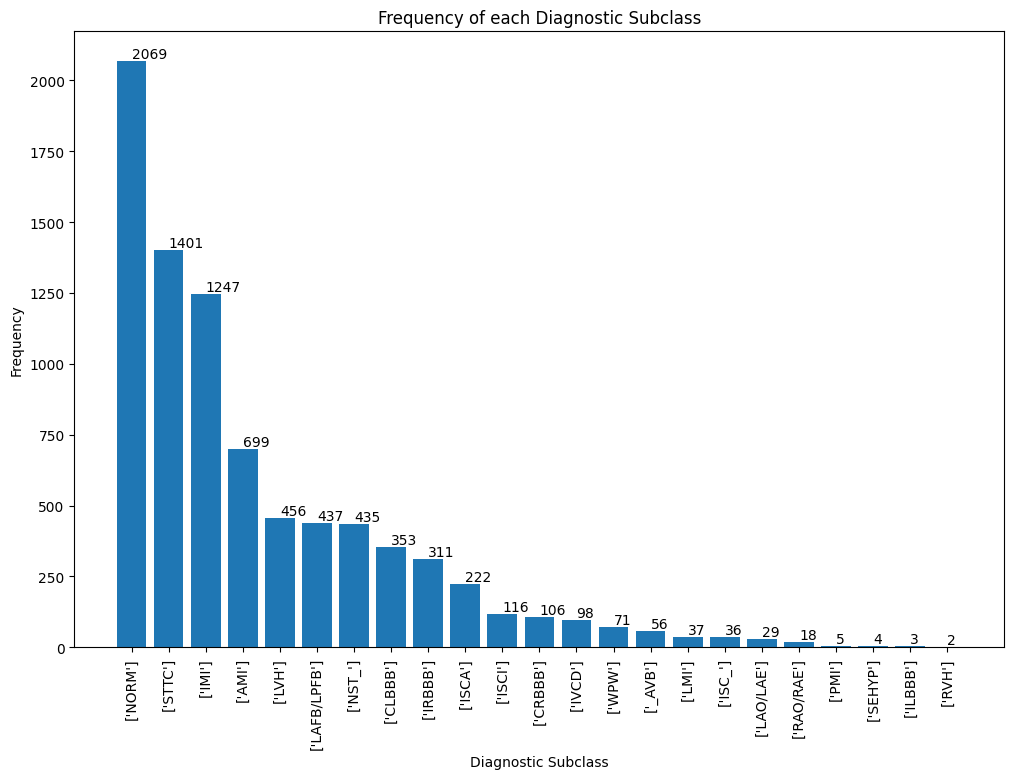

In [7]:
import matplotlib.pyplot as plt

# Convert any list-like objects in 'subclass' to strings
df_orig['subclass'] = df_orig['subclass'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

# Count the number of occurrences of each element in 'subclass'
subclass_counts = df_orig['subclass'].value_counts()

# Plot the frequency of each subclass
plt.figure(figsize=(12,8))
bars = plt.bar(subclass_counts.index, subclass_counts.values)
plt.title('Frequency of each Diagnostic Subclass')
plt.xlabel('Diagnostic Subclass')
plt.ylabel('Frequency')
plt.xticks(rotation='vertical')

# Add count annotations above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom')  # va: vertical alignment

plt.show()


# Preprocessing

## downsampling NORM class

In [8]:
# # Filter out the "NORM" class

# norm_df = df_orig[df_orig['superclass'] == '[\'NORM\']']

# # Randomly sample 6000 records from the "NORM" class to be removed
# to_remove = norm_df.sample(6000, random_state=1)

# # Remove these from the original df
# df = df_orig.drop(to_remove.index)
# df = df.reset_index(drop=True)

# df
df = df_orig

## One Hot

In [9]:
# Make sure each label is in a separate list
df['subclass'] = df['subclass'].apply(lambda x: [x] if isinstance(x, str) else x)

mlb = MultiLabelBinarizer()
label_encoded = mlb.fit_transform(df['subclass'])
df_encoded = pd.concat([df.drop('subclass', axis=1), pd.DataFrame(label_encoded, columns=mlb.classes_)], axis=1)

df_encoded


,record_name,signal,age,sex,['AMI'],['CLBBB'],['CRBBB'],['ILBBB'],['IMI'],['IRBBB'],...,['LVH'],['NORM'],['NST_'],['PMI'],['RAO/RAE'],['RVH'],['SEHYP'],['STTC'],['WPW'],['_AVB']
0,records100/00000/00003_lr,"[[-0.029, -0.079, -0.049, 0.054, 0.011, -0.064...",37.0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,records100/00000/00004_lr,"[[-0.054, -0.138, -0.083, 0.096, 0.015, -0.11,...",24.0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,records100/00000/00008_lr,"[[-0.041, -0.08, -0.039, 0.06, -0.001, -0.06, ...",48.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,records100/00000/00009_lr,"[[-0.145, -0.097, 0.049, 0.121, -0.096, -0.024...",55.0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,records100/00000/00015_lr,"[[-0.049, 0.055, 0.104, -0.003, -0.077, 0.08, ...",17.0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8206,records100/21000/21824_lr,"[[-0.029, -0.064, -0.035, 0.047, 0.003, -0.05,...",69.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8207,records100/21000/21825_lr,"[[-0.049, 0.005, 0.053, 0.022, -0.051, 0.029, ...",59.0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
8208,records100/21000/21826_lr,"[[-0.031, -0.001, 0.03, 0.016, -0.031, 0.014, ...",82.0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8209,records100/21000/21833_lr,"[[-0.052, -0.034, 0.018, 0.043, -0.034, -0.008...",67.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


SPLIT


In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate the target labels (heart condition classes) and the input features
X_ecg = np.array(df_encoded['signal'].tolist())
X_info = df_encoded[[]]  # age and sex as additional features
y = df_encoded.drop(['record_name', 'signal', 'age', 'sex'], axis=1)

# Split the data into training, validation, and test sets
X_ecg_train, X_ecg_test, X_info_train, X_info_test, y_train, y_test = train_test_split(
    X_ecg, X_info, y, test_size=0.3, random_state=12
)
X_ecg_val, X_ecg_test, X_info_val, X_info_test, y_val, y_test = train_test_split(
    X_ecg_test, X_info_test, y_test, test_size=0.5, random_state=12
)

# Apply feature scaling (if needed) on the ECG signal data
# scaler = StandardScaler()
# X_ecg_train = np.array([scaler.fit_transform(sample) for sample in X_ecg_train])
# X_ecg_val = np.array([scaler.transform(sample) for sample in X_ecg_val])
# X_ecg_test = np.array([scaler.transform(sample) for sample in X_ecg_test])

# Check the shapes of the datasets
print("ECG Data Shapes:")
print("Training data:", X_ecg_train.shape)
print("Validation data:", X_ecg_val.shape)
print("Test data:", X_ecg_test.shape)
print("\nInfo Data Shapes:")
print("Training data:", X_info_train.shape)
print("Validation data:", X_info_val.shape)
print("Test data:", X_info_test.shape)
print("\nTarget Labels Shape:")
print("Training labels:", y_train.shape)
print("Validation labels:", y_val.shape)
print("Test labels:", y_test.shape)


ECG Data Shapes:
Training data: (5747, 1000, 12)
Validation data: (1232, 1000, 12)
Test data: (1232, 1000, 12)

Info Data Shapes:
Training data: (5747, 0)
Validation data: (1232, 0)
Test data: (1232, 0)

Target Labels Shape:
Training labels: (5747, 23)
Validation labels: (1232, 23)
Test labels: (1232, 23)


## Upsample lowest class

In [11]:
# import numpy as np
# from sklearn.utils import resample

# # Get column names
# class_labels = y_train.columns

# # Get index of the max value in each row (which will be 1 in one-hot encoding)
# label_indices = np.argmax(y_train.values, axis=1)

# # Map the index to the corresponding class label
# y_train_single_column = np.array([class_labels[idx] for idx in label_indices])

# # Now create train_df
# train_df = pd.DataFrame({'signal': [signal for signal in X_ecg_train], 'superclass': y_train_single_column})


# def add_noise(data, noise_factor=0.01):
#     noise = np.random.normal(size=data.shape)
#     augmented_data = data + noise_factor * noise
#     return augmented_data

# # Separate the 'HYP' class
# hyp_df = train_df[train_df['superclass'] == '[\'HYP\']']

# # Determine how many instances you need to resample
# n_samples = 1000  # adjust this value as needed

# # Resample the 'HYP' class
# hyp_upsampled = resample(hyp_df,
#                          replace=True,  # sample with replacement
#                          n_samples=n_samples,  # to match number in majority class
#                          random_state=1)  # reproducible results

# # Add noise to the resampled 'HYP' data
# # Assuming 'ecg_data' column contains the ECG data

# hyp_upsampled['signal'] = hyp_upsampled['signal'].apply(add_noise)


# # Create labels for 'HYP' class
# hyp_label = np.zeros(len(class_labels))
# hyp_label[class_labels.get_loc('[\'HYP\']')] = 1  # Assuming 'HYP' is one of the labels

# # Count of original 'HYP' instances
# original_hyp_count = len(hyp_df)

# # Resample and add noise to the 'HYP' class
# hyp_upsampled = resample(hyp_df, replace=True, n_samples=n_samples, random_state=1)
# hyp_upsampled['signal'] = hyp_upsampled['signal'].apply(add_noise)

# # Calculate how many new 'HYP' instances have been created
# new_hyp_count = len(hyp_upsampled) - original_hyp_count

# # Create corresponding labels for the new 'HYP' instances
# new_hyp_labels = np.repeat([hyp_label], new_hyp_count, axis=0)

# # Add new 'HYP' labels to y_train
# y_train = np.vstack((y_train, new_hyp_labels))

# # Combine the upsampled 'HYP' class with the rest of the training data
# train_df = pd.concat([train_df[train_df['superclass'] != '[\'HYP\']'], hyp_upsampled])
# train_df = train_df.reset_index(drop=True)

# # Transform 'train_df' back into your training dataset 'X_ecg_train'
# X_ecg_train = np.stack(train_df['signal'].values)



# # Choose one signal from the upsampled dataframe
# original_signal = hyp_upsampled['signal'].iloc[0]

# # Apply noise to this signal
# noisy_signal = add_noise(original_signal)

# # Plot original signal (first lead)
# plt.figure(figsize=(15, 3))
# plt.plot(original_signal[:, 0])  # select the first lead
# plt.title("Original ECG Signal (Lead 1)")
# plt.show()

# # Plot noisy signal (first lead)
# plt.figure(figsize=(15, 3))
# plt.plot(noisy_signal[:, 0])  # select the first lead
# plt.title("Noisy ECG Signal (Lead 1)")
# plt.show()



## Distribution of diseases SNOMED

In [12]:
# plt.figure(figsize=(10, 6))

# # Bar chart
# bars = plt.bar(disease_counts_sorted.index.astype(str), disease_counts_sorted.values)

# # Add data values to the top of the bars
# for bar in bars:
#     yval = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, int(yval), ha='center', va='bottom')

# plt.xlabel('SNOMED Disease Code')
# plt.ylabel('Number of Patients')
# plt.title('Distribution of Diseases')
# plt.xticks(rotation=90)
# plt.tight_layout()
# plt.show()


## test display

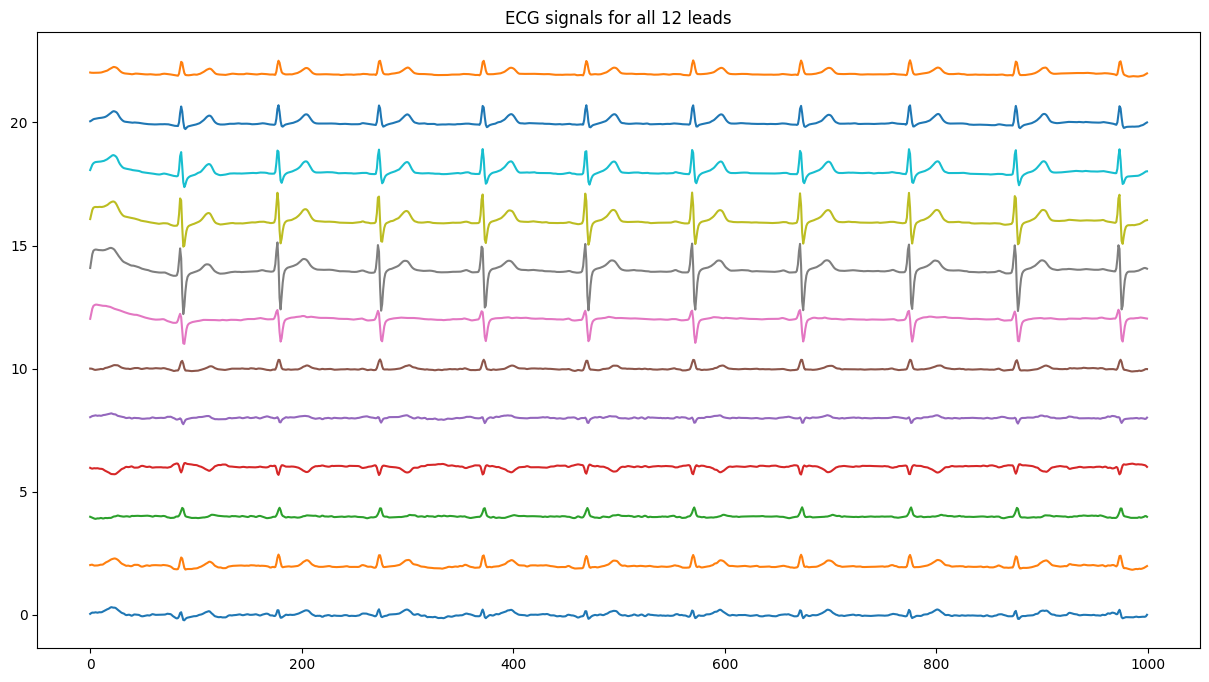

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))

# Create a list to store all ECG signals
all_ecgs = []

# Iterate over the 12 leads
for i in range(12):
    single_ecg = []
    for sublist in df_encoded.loc[3,'signal']:  # Get the data for one patient
        single_ecg.append(sublist[i])  # Get data for one lead

    signals, info = nk.ecg_process(single_ecg, sampling_rate=100)
    cleaned_ecg = signals["ECG_Clean"]

    all_ecgs.append(cleaned_ecg)

# Combine all ECG signals into a single 2D array
all_ecgs = np.stack(all_ecgs)

# Plot each ECG lead with a slight vertical shift for better visibility
for i, ecg in enumerate(all_ecgs):
    plt.plot(ecg + i*2)  # Shift each lead by 200 units

plt.title('ECG signals for all 12 leads')
plt.show()


## Remove last beat if incomplete

In [14]:
# cpt=0
# def clean_heartbeats(row):
#     global cpt
#     all_leads = []
#     for sublist in row['signal']:
#         all_leads.append(sublist)  # Get all leads

#     # Process lead II to get R-peaks
#     single_ecg_lead_II = [sublist[1] for sublist in row['signal']]  # LEAD II
#     try:
#         signals, info = nk.ecg_process(single_ecg_lead_II, sampling_rate=100)
#     except ValueError as e:
#         print(f"An error occurred while processing the ECG data for record {row['record_name']}: {e}")
#         return single_ecg_lead_II  # Return the original ECG signal if an error occurs

#     rpeaks = info["ECG_R_Peaks"]
#     # Remove NaN values from rpeaks
#     rpeaks = rpeaks[~np.isnan(rpeaks)]
#     try:
#         heartbeats_II = np.split(single_ecg_lead_II, rpeaks.astype(int))
#     except ValueError as e:
#         print(f"An error occurred while splitting the ECG data for record {row['record_name']}: {e}")
#         return single_ecg_lead_II  # Return the original ECG signal if an error occurs

#     # Check if the last heartbeat is incomplete (i.e., significantly shorter than the others)
#     average_heartbeat_length = np.mean([len(heartbeat) for heartbeat in heartbeats_II])
#     if len(heartbeats_II[-1]) < average_heartbeat_length * 0.75:
#         rpeaks = rpeaks[:-1]  # Remove the last R-peak
#         cpt += 1

#     # Use the R-peaks to segment all leads and remove incomplete heartbeats
#     cleaned_ecg_leads = []
#     for lead in all_leads:
#         try:
#             heartbeats = np.split(lead, rpeaks.astype(int))
#         except ValueError as e:
#             print(f"An error occurred while splitting the ECG data for record {row['record_name']}: {e}")
#             return lead  # Return the original ECG signal if an error occurs

#         if len(heartbeats[-1]) < average_heartbeat_length * 0.75:
#             heartbeats = heartbeats[:-1]  # Remove the last heartbeat if incomplete
#         # Concatenate the heartbeats back into a single ECG signal
#         cleaned_ecg_lead = np.concatenate(heartbeats)
#         cleaned_ecg_leads.append(cleaned_ecg_lead)

#     # Stack the cleaned leads back together
#     cleaned_ecg = np.stack(cleaned_ecg_leads, axis=-1)
#     return cleaned_ecg


# # Apply the function to the 'signal' column of the DataFrame
# df_encoded_removed_beats = df_encoded
# df_encoded_removed_beats['signal'] = df_encoded.apply(clean_heartbeats, axis=1)
# print(df_encoded_removed_beats)
# print(df_encoded_removed_beats['signal'][0])
# print(df_encoded_removed_beats['signal'][0][0])
# print(df_encoded_removed_beats['signal'][0][0][0])
# print(df_encoded_removed_beats.shape)
# print(f"number of incomplete beats patients: {cpt}/{len(df_encoded.index)}")
# df_encoded_removed_beats.to_pickle('df_encoded_removed_beats.pkl')



## Notch filer - 50hz cleaning

In [15]:
# # Define the sample rate and the frequencies for the notch and low-pass filters
# sample_rate = 100
# notch_freq = 50
# low_pass_freq = 15  # Adjust the low-pass frequency to maintain similar filtering characteristics

# def design_filters(sample_rate, notch_freq, low_pass_freq):
#     # Design the notch filter
#     nyquist = 0.5 * sample_rate
#     freq_ratio = notch_freq / nyquist
#     notch_filter = iirnotch(freq_ratio, 30)  # 30 is the quality factor of the filter

#     # Design the low-pass filter
#     low_pass_filter = butter(5, low_pass_freq / nyquist, btype='low')

#     return notch_filter, low_pass_filter

# # Design the filters
# notch_filter, low_pass_filter = design_filters(sample_rate, notch_freq, low_pass_freq)
# # Define a function to apply the filters
# def apply_filters(data, notch_filter, low_pass_filter):
#     # Apply the notch filter
#     data = lfilter(*notch_filter, data)

#     # Apply the low-pass filter
#     data = lfilter(*low_pass_filter, data)

#     return data
# # Apply the filters to the data
# print(df_encoded.shape)
# df_encoded['signal'] = df_encoded['signal'].apply(lambda signal: apply_filters(signal, notch_filter, low_pass_filter))
# print(df_encoded.shape)


## Smoothen signal cleaning

In [16]:
# # def moving_average(signal, window_size):
# #     # If the signal has more than one channel, apply the moving average to each channel
# #     if signal.ndim > 1:
# #         return np.array([np.convolve(channel, np.ones(window_size) / window_size, mode='same') for channel in signal.T]).T
# #     # If the signal is only one channel, apply the moving average normally
# #     else:
# #         return np.convolve(signal, np.ones(window_size) / window_size, mode='same')

# # df_encoded['signal'] = df_encoded['signal'].apply(lambda signal: moving_average(signal, window_size=3))

# # df_encoded['signal'] = df_encoded['signal'].apply(lambda signal: butter_lowpass_filter(signal, cutoff, fs, order))

# import pywt
# from scipy.stats import median_abs_deviation as mad

# def maddest(d, axis=None):  # Mean Absolute Deviation
#     return np.mean(np.absolute(d - np.mean(d, axis)), axis)

# def wavelet_smooth(signal, wavelet="db5", level=1):
#     coeff = pywt.wavedec(signal, wavelet, mode="per")
#     sigma = (1/0.6745) * maddest(coeff[-level])
#     uthresh = sigma * np.sqrt(2*np.log(len(signal)))
#     coeff[1:] = (pywt.threshold(i, value=uthresh, mode="soft") for i in coeff[1:])
#     reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per")
#     return reconstructed_signal

# df_encoded['signal'] = df_encoded['signal'].apply(lambda signal: wavelet_smooth(signal))



## Remove Outliers

In [17]:

# # Compute the mean and standard deviation for each record
# means = np.array([np.mean(record) for record in df_encoded['signal']])
# std_devs = np.array([np.std(record) for record in df_encoded['signal']])

# # Compute the average mean and standard deviation
# avg_mean = np.mean(means)
# avg_std_dev = np.mean(std_devs)

# # Compute the standard deviation of the means and standard deviations
# std_mean = np.std(means)
# std_std_dev = np.std(std_devs)

# # Identify outliers as records where the mean or standard deviation is more than 3 standard deviations from the average
# outlier_indices = np.where(
#     (np.abs(means - avg_mean) > 3 * std_mean) |
#     (np.abs(std_devs - avg_std_dev) > 3 * std_std_dev)
# )[0]

# # Remove outliers from df
# df_cleaned = df_encoded.drop(outlier_indices)
# print(df_cleaned.shape)
# print(len(df_cleaned['signal'][0]))
# print(df_cleaned['signal'][0][0])
# #df_cleaned = df_encoded

## Normalization

In [18]:
# from tqdm import tqdm

# def normalize_patient_signals(patient_signals, patient_index):
#     scaler = MinMaxScaler(feature_range=(-1, 1))
#     patient_ecgs_normalized = []

#     for i in range(12):
#         single_ecg = patient_signals[:, i]

#         try:
#             signals, info = nk.ecg_process(single_ecg, sampling_rate=100)
#             cleaned_ecg = signals["ECG_Clean"]

#             # Normalize the ECG signal
#             normalized_ecg = scaler.fit_transform(cleaned_ecg.to_numpy().reshape(-1, 1))

#             # Center the normalized ECG signal around 0
#             normalized_centered_ecg = normalized_ecg - np.mean(normalized_ecg)
#             patient_ecgs_normalized.append(normalized_centered_ecg.flatten())

#         except ValueError:
#             print(f"Error processing ECG signal for patient at index {patient_index}. Plotting signal and skipping...")
#             plt.figure(figsize=(10, 4))
#             plt.plot(single_ecg)
#             plt.title(f'ECG signal causing error for patient at index {patient_index}')
#             plt.show()
#             return None  # Return None to indicate an error

#     # Combine all normalized ECG signals for current patient into a single 2D array
#     return np.stack(patient_ecgs_normalized)


# # Apply the function to each row in the 'signal' column, and also pass the index to the function
# for index in tqdm(df_encoded.index):
#     df_encoded.at[index, 'signal'] = normalize_patient_signals(df_encoded.loc[index, 'signal'], index)

# # Drop rows where 'signal' is None (i.e., the ECG processing failed)
# df_encoded = df_encoded.dropna(subset=['signal'])


# df_cleaned = df_encoded


In [19]:
# def minmax_scale_image(image):
#     min_val = image.min()
#     max_val = image.max()
#     scaled_image = (image - min_val) / (max_val - min_val)
#     return scaled_image

# # Apply the minmax_scale_image function to each 2D image in the 'signal' column
# df_encoded['signal'] = df_encoded['signal'].apply(minmax_scale_image)


Random Forest Test


In [20]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier

# # Flatten the data
# X_ecg_train_flattened = X_ecg_train.reshape(X_ecg_train.shape[0], -1)
# X_ecg_val_flattened = X_ecg_val.reshape(X_ecg_val.shape[0], -1)
# X_ecg_test_flattened = X_ecg_test.reshape(X_ecg_test.shape[0], -1)

# # Convert DataFrames to NumPy arrays and then to label-encoded form
# y_train_single = np.argmax(y_train.values, axis=1)
# y_val_single = np.argmax(y_val.values, axis=1)
# y_test_single = np.argmax(y_test.values, axis=1)

# # Define the parameter grid
# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [None, 20],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2],
#     'max_features': ['auto']
# }

# # Create a base model
# rf = RandomForestClassifier(random_state=12)

# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
#                            cv = 2, n_jobs = -1, verbose = 2)

# # Fit the grid search to the data
# grid_search.fit(X_ecg_train_flattened, y_train_single)

# # Print the best parameters
# print(grid_search.best_params_)

# # Use the best model
# best_grid = grid_search.best_estimator_

# # Make predictions using the best model
# y_val_pred = best_grid.predict(X_ecg_val_flattened)


ResNet Test


In [21]:
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

def residual_block(X, filters):
    # Save the input value
    X_shortcut = X

    # First component of main path
    X = Conv1D(filters, kernel_size=8, strides=1, padding="same")(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv1D(filters, kernel_size=5, strides=1, padding="same")(X)
    X = BatchNormalization()(X)

    # Add shortcut value to main path
    X_shortcut = Conv1D(filters, kernel_size=3, strides=1, padding="same")(X_shortcut)
    X_shortcut = BatchNormalization()(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def create_model(input_shape=(1000,12), classes=23):
    # Define the input
    X_input = Input(input_shape)

    # Stage 1
    X = Conv1D(64, kernel_size=7, strides=2)(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPooling1D(pool_size=3, strides=2)(X)

    # Stage 2
    X = residual_block(X, filters=64)

    # Stage 3
    X = residual_block(X, filters=128)

    # Stage 4
    X = residual_block(X, filters=256)

    # Output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax')(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet')

    return model

# Call the function to create the model
model_resnet = create_model(input_shape=(1000, 12), classes=23)

# Compile the model
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
model_resnet.summary()

history_resnet = model_resnet.fit(
    X_ecg_train,
    y_train,
    validation_data=(X_ecg_val, y_val),
    epochs=20,  # specify the number of epochs
    batch_size=32,  # specify your batch size
    #class_weight = class_weight
)


Model: "ResNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000, 12)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 497, 64)      5440        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 497, 64)     256         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 497, 64)      0           ['batch_normalization[0][0]'

In [22]:
from sklearn.metrics import roc_auc_score, classification_report

# Ensure your data is correctly shaped. If your data preparation step is correct,
# X_ecg_test should already have the shape of (num_instances, 1000, 12).
# In case it doesn't, reshape it as necessary.

# Predict with the reshaped data
y_pred = model_resnet.predict(X_ecg_test)
print(y_pred)
# Convert the predictions from probabilities to binary outputs (0 and 1)
# This is necessary for multi-label classification
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# ROC AUC
roc_auc = roc_auc_score(y_test, y_pred, average='samples')  # Multi-label case
print(f'ROC AUC Score: {roc_auc}')

# Classification Report
target_names = ['AMI', 'CLBBB', 'CRBBB', 'ILBBB', 'IMI', 'IRBBB', 'ISCA', 'ISCI', 'ISC_', 'IVCD', 'LAFB/LPFB', 'LAO/LAE', 'LMI', 'LVH', 'NORM', 'NST_', 'PMI', 'RAO/RAE', 'RVH', 'SEHYP', 'STTC', 'WPW', '_AVB']
print(classification_report(y_test, y_pred_binary, target_names=target_names))


39/39 [==============================] - 1s 6ms/step
[[1.48647345e-07 1.07485809e-09 3.48056284e-12 ... 3.64434118e-06
  1.08417708e-09 6.84308432e-08]
 [9.70022029e-06 5.61236732e-07 5.77726478e-10 ... 8.20283080e-04
  4.16925388e-07 1.74317043e-04]
 [4.84877091e-04 5.24358768e-07 1.33712078e-07 ... 3.22846376e-04
  4.08709457e-06 2.16800800e-06]
 ...
 [3.99147469e-12 7.77407056e-13 6.84759459e-14 ... 1.02412150e-06
  1.05801395e-10 2.21830276e-10]
 [2.72031841e-09 5.96726661e-12 2.03758095e-08 ... 2.42548063e-03
  3.85561097e-11 1.07447750e-06]
 [8.76590889e-09 2.93083446e-09 5.80609949e-10 ... 5.17527624e-05
  3.98661298e-10 3.18314486e-09]]
ROC AUC Score: 0.9150494391971664
              precision    recall  f1-score   support

         AMI       0.58      0.46      0.52       125
       CLBBB       0.96      0.90      0.93        49
       CRBBB       0.64      0.69      0.67        13
       ILBBB       0.00      0.00      0.00         0
         IMI       0.51      0.64      0.5

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_resnet.evaluate(X_ecg_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

39/39 [==============================] - 0s 8ms/step - loss: 4.3284 - categorical_accuracy: 0.4992
Test Loss: 4.328412055969238
Test Accuracy: 0.49918830394744873


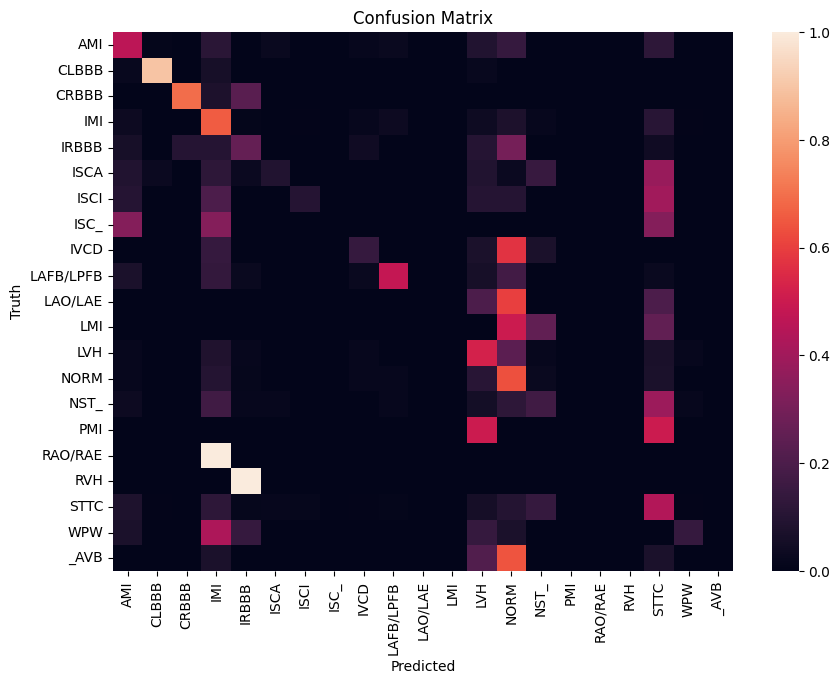

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_test_binary = np.argmax(y_test.values, axis=-1)
y_pred_binary = np.argmax(y_pred, axis=1)

# compute the confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_binary, normalize = 'true')

class_names = ['AMI', 'CLBBB', 'CRBBB', 'ILBBB', 'IMI', 'IRBBB', 'ISCA', 'ISCI', 'ISC_', 'IVCD', 'LAFB/LPFB', 'LAO/LAE', 'LMI', 'LVH', 'NORM', 'NST_', 'PMI', 'RAO/RAE', 'RVH', 'SEHYP', 'STTC', 'WPW', '_AVB']
class_dict = {i: name for i, name in enumerate(class_names)}

test_classes = np.unique(y_test_binary)
pred_classes = np.unique(y_pred_binary)
all_classes = np.union1d(test_classes, pred_classes)

target_names_matrix = [class_dict[i] for i in all_classes]


# use seaborn to create a heatmap visualization of the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm,xticklabels=target_names_matrix, yticklabels=target_names_matrix)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()

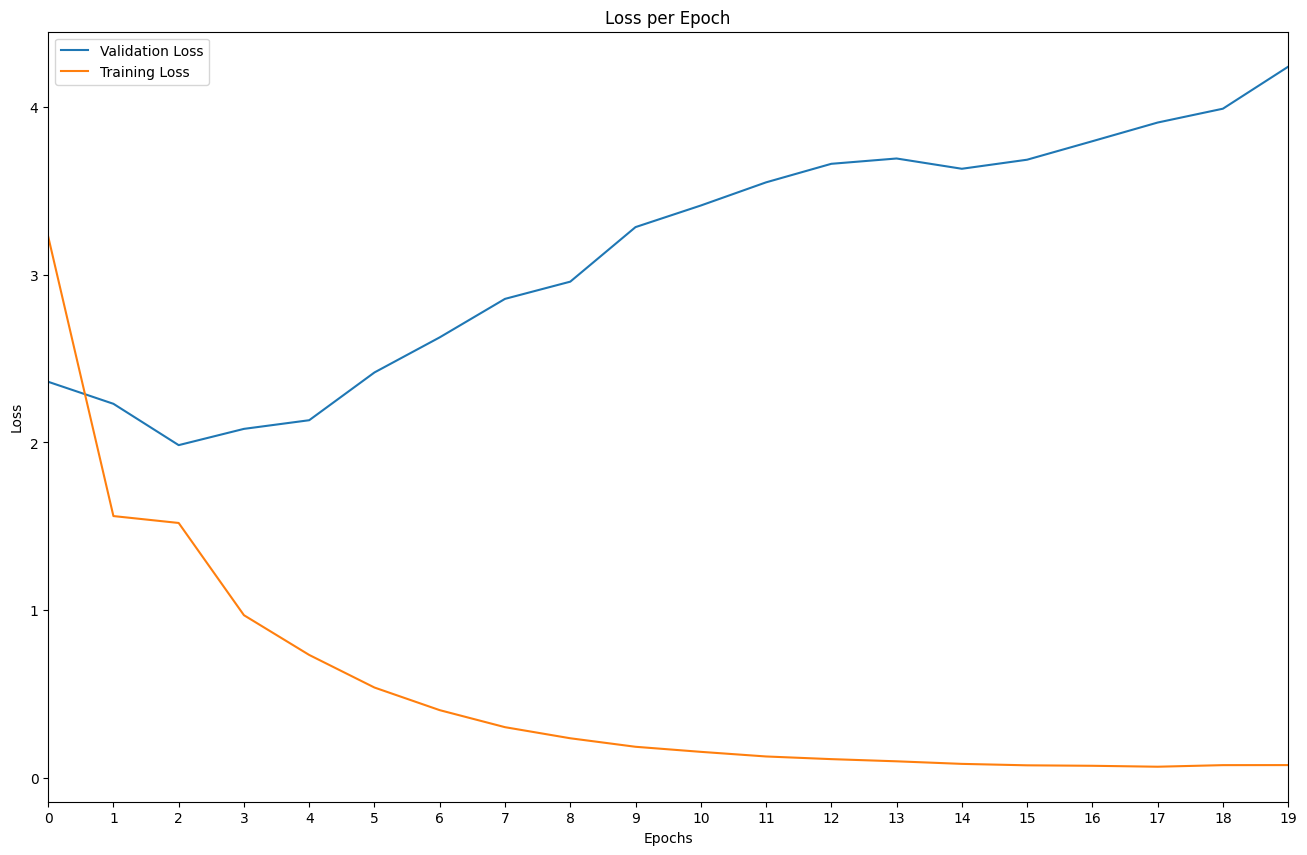

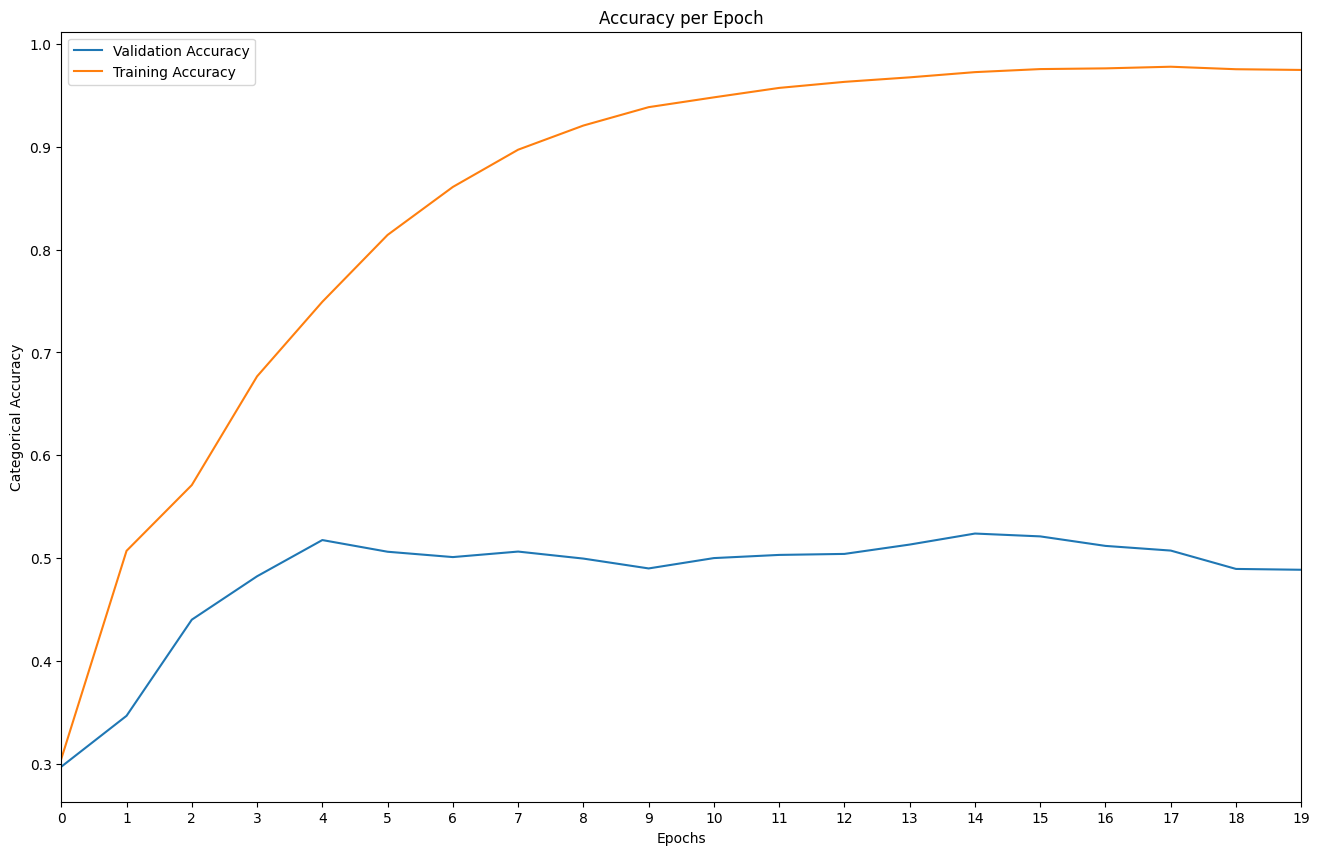

In [25]:
def plot_smooth_loss(history, key='loss', window=5):
    plt.figure(figsize=(16,10))

    val = pd.Series(history.history['val_'+key])
    val_smooth = val.rolling(window=window, center=True).mean().fillna(val)
    plt.plot(val_smooth, label='Validation Loss')

    train = pd.Series(history.history[key])
    train_smooth = train.rolling(window=window, center=True).mean().fillna(train)
    plt.plot(train_smooth, label='Training Loss')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    # Find the maximum epoch for the x-axis limit
    max_epoch = max(history.epoch)
    plt.xlim([0, max_epoch])

    # Set the x-axis ticks to integers
    plt.xticks(np.arange(0, max_epoch+1, step=1))
    plt.title('Loss per Epoch')

# Plot the loss
plot_smooth_loss(history_resnet)

def plot_smooth_accuracy(history, key='categorical_accuracy', window=5):
    plt.figure(figsize=(16,10))

    val = pd.Series(history.history['val_'+key])
    val_smooth = val.rolling(window=window, center=True).mean().fillna(val)
    plt.plot(val_smooth, label='Validation Accuracy')

    train = pd.Series(history.history[key])
    train_smooth = train.rolling(window=window, center=True).mean().fillna(train)
    plt.plot(train_smooth, label='Training Accuracy')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    # Find the maximum epoch for the x-axis limit
    max_epoch = max(history.epoch)
    plt.xlim([0, max_epoch])

    # Set the x-axis ticks to integers
    plt.xticks(np.arange(0, max_epoch+1, step=1))
    plt.title('Accuracy per Epoch')

# Plot the accuracy
plot_smooth_accuracy(history_resnet)


## Transformer Test

In [26]:
import tensorflow as tf
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

inputs = layers.Input(shape=(1000, 12))
x = transformer_encoder(inputs, head_size=64, num_heads=2, ff_dim=512, dropout=0.1)

# The Global Average Pooling layer and output layer
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(23, activation="softmax")(x)

model_tran = tf.keras.Model(inputs=inputs, outputs=outputs)

model_tran.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)


# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Pass it as a callback to the fit function
history_tran = model_tran.fit(X_ecg_train, y_train, batch_size=32, epochs=100, validation_data=(X_ecg_val, y_val), callbacks=[early_stopping])


Epoch 1/100
180/180 [==============================] - 16s 68ms/step - loss: 2.4635 - categorical_accuracy: 0.2916 - val_loss: 2.1919 - val_categorical_accuracy: 0.3360
Epoch 2/100
180/180 [==============================] - 12s 66ms/step - loss: 2.0562 - categorical_accuracy: 0.3553 - val_loss: 2.0608 - val_categorical_accuracy: 0.3515
Epoch 3/100
180/180 [==============================] - 12s 67ms/step - loss: 1.9740 - categorical_accuracy: 0.3741 - val_loss: 2.0127 - val_categorical_accuracy: 0.3547
Epoch 4/100
180/180 [==============================] - 12s 66ms/step - loss: 1.9302 - categorical_accuracy: 0.3868 - val_loss: 1.9772 - val_categorical_accuracy: 0.3685
Epoch 5/100
180/180 [==============================] - 12s 66ms/step - loss: 1.8902 - categorical_accuracy: 0.4019 - val_loss: 1.9495 - val_categorical_accuracy: 0.3823
Epoch 6/100
180/180 [==============================] - 12s 66ms/step - loss: 1.8622 - categorical_accuracy: 0.4127 - val_loss: 1.9249 - val_categorical_acc

KeyboardInterrupt: ignored

In [ ]:
def plot_smooth_loss(history, key='loss', window=5):
    plt.figure(figsize=(16,10))

    val = pd.Series(history.history['val_'+key])
    val_smooth = val.rolling(window=window, center=True).mean().fillna(val)
    plt.plot(val_smooth, label='Validation Loss')

    train = pd.Series(history.history[key])
    train_smooth = train.rolling(window=window, center=True).mean().fillna(train)
    plt.plot(train_smooth, label='Training Loss')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    # Find the maximum epoch for the x-axis limit
    max_epoch = max(history.epoch)
    plt.xlim([0, max_epoch])

    # Set the x-axis ticks to integers
    plt.xticks(np.arange(0, max_epoch+1, step=1))
    plt.title('Loss per Epoch')

# Plot the loss
plot_smooth_loss(history_tran)

def plot_smooth_accuracy(history, key='categorical_accuracy', window=5):
    plt.figure(figsize=(16,10))

    val = pd.Series(history.history['val_'+key])
    val_smooth = val.rolling(window=window, center=True).mean().fillna(val)
    plt.plot(val_smooth, label='Validation Accuracy')

    train = pd.Series(history.history[key])
    train_smooth = train.rolling(window=window, center=True).mean().fillna(train)
    plt.plot(train_smooth, label='Training Accuracy')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    # Find the maximum epoch for the x-axis limit
    max_epoch = max(history.epoch)
    plt.xlim([0, max_epoch])

    # Set the x-axis ticks to integers
    plt.xticks(np.arange(0, max_epoch+1, step=1))
    plt.title('Accuracy per Epoch')

# Plot the accuracy
plot_smooth_accuracy(history_tran)


In [ ]:
from sklearn.metrics import roc_auc_score, classification_report

# Ensure your data is correctly shaped. If your data preparation step is correct,
# X_ecg_test should already have the shape of (num_instances, 1000, 12).
# In case it doesn't, reshape it as necessary.

# Predict with the reshaped data
y_pred = model_tran.predict(X_ecg_test)

# Convert the predictions from probabilities to binary outputs (0 and 1)
# This is necessary for multi-label classification
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# ROC AUC
roc_auc = roc_auc_score(y_test, y_pred, average='samples')  # Multi-label case
print(f'ROC AUC Score: {roc_auc}')

# Classification Report
target_names = ['AMI', 'CLBBB', 'CRBBB', 'ILBBB', 'IMI', 'IRBBB', 'ISCA', 'ISCI', 'ISC_', 'IVCD', 'LAFB/LPFB', 'LAO/LAE', 'LMI', 'LVH', 'NORM', 'NST_', 'PMI', 'RAO/RAE', 'RVH', 'SEHYP', 'STTC', 'WPW', '_AVB']
print(classification_report(y_test, y_pred_binary, target_names=target_names))


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_test_binary = np.argmax(y_test.values, axis=-1)
y_pred_binary = np.argmax(y_pred, axis=1)

# compute the confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_binary, normalize = 'true')

class_names = ['AMI', 'CLBBB', 'CRBBB', 'ILBBB', 'IMI', 'IRBBB', 'ISCA', 'ISCI', 'ISC_', 'IVCD', 'LAFB/LPFB', 'LAO/LAE', 'LMI', 'LVH', 'NORM', 'NST_', 'PMI', 'RAO/RAE', 'RVH', 'SEHYP', 'STTC', 'WPW', '_AVB']
class_dict = {i: name for i, name in enumerate(class_names)}

test_classes = np.unique(y_test_binary)
pred_classes = np.unique(y_pred_binary)
all_classes = np.union1d(test_classes, pred_classes)

target_names_matrix = [class_dict[i] for i in all_classes]


# use seaborn to create a heatmap visualization of the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, fmt='.2f',xticklabels=target_names_matrix, yticklabels=target_names_matrix)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()

RNN


In [29]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

def create_model(input_shape=(1000, 12), num_classes=23):
    # Define an input for the series
    input_series = layers.Input(shape=input_shape)

    # Apply LSTM to the series
    x = layers.LSTM(64)(input_series)

    # Add a dense layer
    x = layers.Dense(64, activation="relu")(x)

    # Add a dropout layer for regularization
    x = layers.Dropout(0.5)(x)

    # Add the final classification (output) layer
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    # Define the model
    model = Model(inputs=input_series, outputs=outputs)

    # Compile the model
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

# Call the function to create the model
model_rnn = create_model(input_shape=(1000, 12), num_classes=23)

# Print the model summary
model_rnn.summary()

# Then pass the data to the fit method
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Pass it as a callback to the fit function
history_rnn = model_rnn.fit(X_ecg_train, y_train, batch_size=32, epochs=100, validation_data=(X_ecg_val, y_val), callbacks=[early_stopping])


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1000, 12)]        0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                19712     
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 23)                1495      
                                                                 
Total params: 25,367
Trainable params: 25,367
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
180/180 [==============================] - 

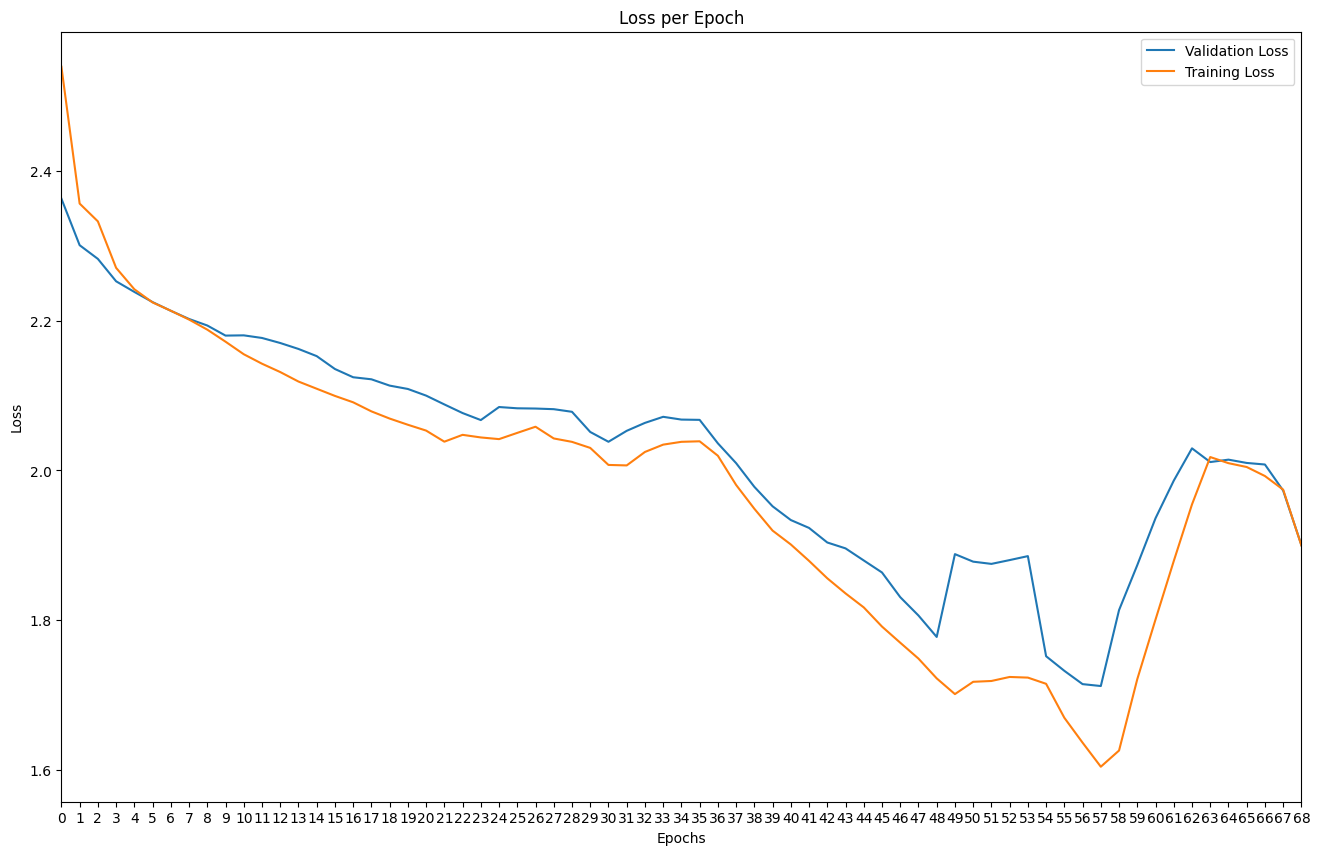

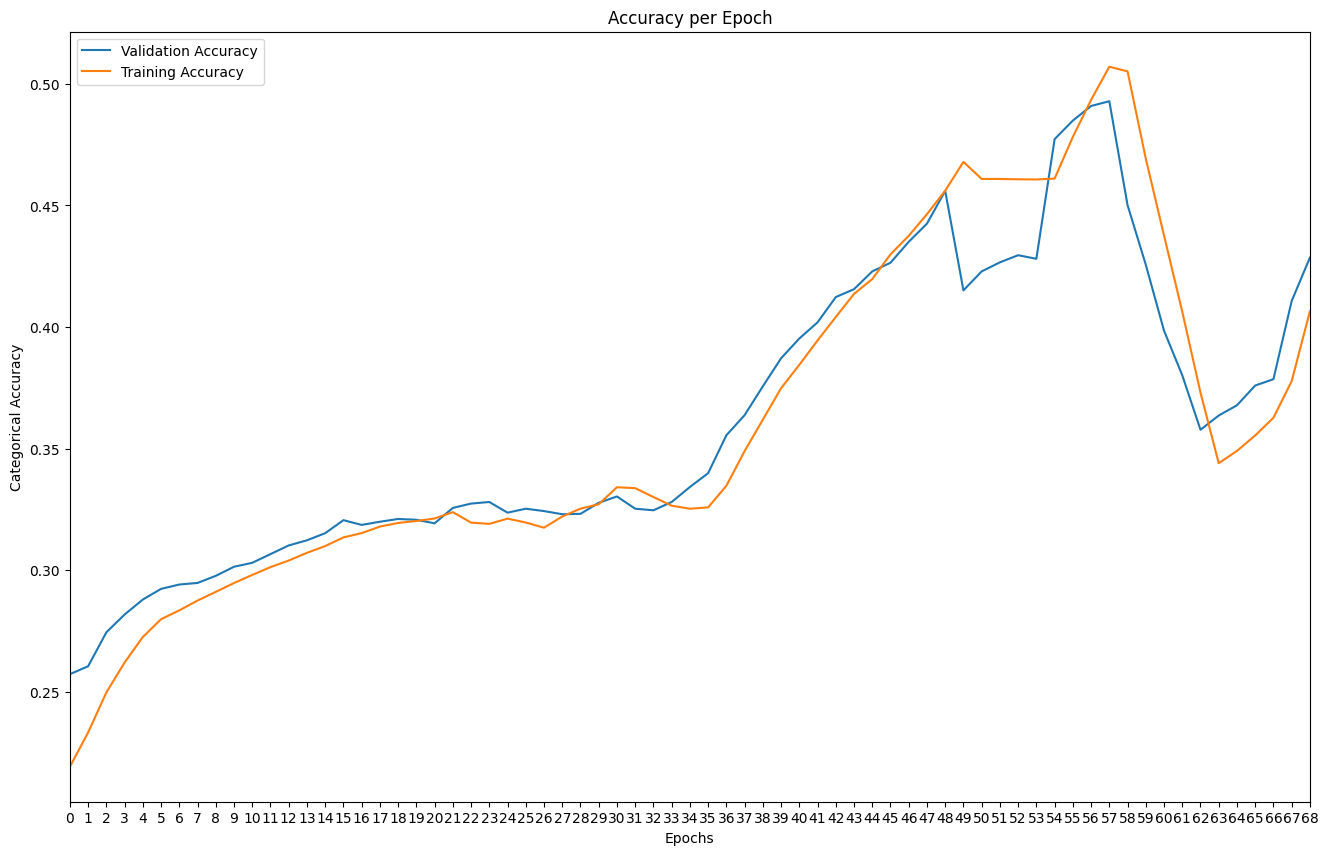

In [30]:
def plot_smooth_loss(history, key='loss', window=5):
    plt.figure(figsize=(16,10))

    val = pd.Series(history.history['val_'+key])
    val_smooth = val.rolling(window=window, center=True).mean().fillna(val)
    plt.plot(val_smooth, label='Validation Loss')

    train = pd.Series(history.history[key])
    train_smooth = train.rolling(window=window, center=True).mean().fillna(train)
    plt.plot(train_smooth, label='Training Loss')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    # Find the maximum epoch for the x-axis limit
    max_epoch = max(history.epoch)
    plt.xlim([0, max_epoch])

    # Set the x-axis ticks to integers
    plt.xticks(np.arange(0, max_epoch+1, step=1))
    plt.title('Loss per Epoch')

# Plot the loss
plot_smooth_loss(history_rnn)

def plot_smooth_accuracy(history, key='categorical_accuracy', window=5):
    plt.figure(figsize=(16,10))

    val = pd.Series(history.history['val_'+key])
    val_smooth = val.rolling(window=window, center=True).mean().fillna(val)
    plt.plot(val_smooth, label='Validation Accuracy')

    train = pd.Series(history.history[key])
    train_smooth = train.rolling(window=window, center=True).mean().fillna(train)
    plt.plot(train_smooth, label='Training Accuracy')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    # Find the maximum epoch for the x-axis limit
    max_epoch = max(history.epoch)
    plt.xlim([0, max_epoch])

    # Set the x-axis ticks to integers
    plt.xticks(np.arange(0, max_epoch+1, step=1))
    plt.title('Accuracy per Epoch')

# Plot the accuracy
plot_smooth_accuracy(history_rnn)


In [31]:
from sklearn.metrics import roc_auc_score, classification_report

# Ensure your data is correctly shaped. If your data preparation step is correct,
# X_ecg_test should already have the shape of (num_instances, 1000, 12).
# In case it doesn't, reshape it as necessary.

# Predict with the reshaped data
y_pred = model_rnn.predict(X_ecg_test)

# Convert the predictions from probabilities to binary outputs (0 and 1)
# This is necessary for multi-label classification
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# ROC AUC
roc_auc = roc_auc_score(y_test, y_pred, average='samples')  # Multi-label case
print(f'ROC AUC Score: {roc_auc}')

# Classification Report
# ['CD']	['HYP']	['MI']	['NORM']	['STTC']
target_names = ['AMI', 'CLBBB', 'CRBBB', 'ILBBB', 'IMI', 'IRBBB', 'ISCA', 'ISCI', 'ISC_', 'IVCD', 'LAFB/LPFB', 'LAO/LAE', 'LMI', 'LVH', 'NORM', 'NST_', 'PMI', 'RAO/RAE', 'RVH', 'SEHYP', 'STTC', 'WPW', '_AVB']
#target_names = ['CD','MI','NORM','STTC']
print(classification_report(y_test, y_pred_binary, target_names=target_names))


39/39 [==============================] - 1s 11ms/step
ROC AUC Score: 0.90241292798111
              precision    recall  f1-score   support

         AMI       0.00      0.00      0.00       125
       CLBBB       0.78      0.59      0.67        49
       CRBBB       0.00      0.00      0.00        13
       ILBBB       0.00      0.00      0.00         0
         IMI       0.52      0.12      0.20       184
       IRBBB       0.00      0.00      0.00        50
        ISCA       0.00      0.00      0.00        34
        ISCI       0.00      0.00      0.00        10
        ISC_       0.00      0.00      0.00         3
        IVCD       0.00      0.00      0.00        14
   LAFB/LPFB       0.80      0.44      0.57        81
     LAO/LAE       0.00      0.00      0.00         5
         LMI       0.00      0.00      0.00         4
         LVH       0.52      0.29      0.37        59
        NORM       0.57      0.01      0.03       298
        NST_       0.00      0.00      0.00      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:
test_loss, test_accuracy = model_rnn.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

52/52 [==============================] - 2s 18ms/step - loss: 2.8082 - categorical_accuracy: 0.0889
Test Loss: 2.808150291442871
Test Accuracy: 0.08886183798313141


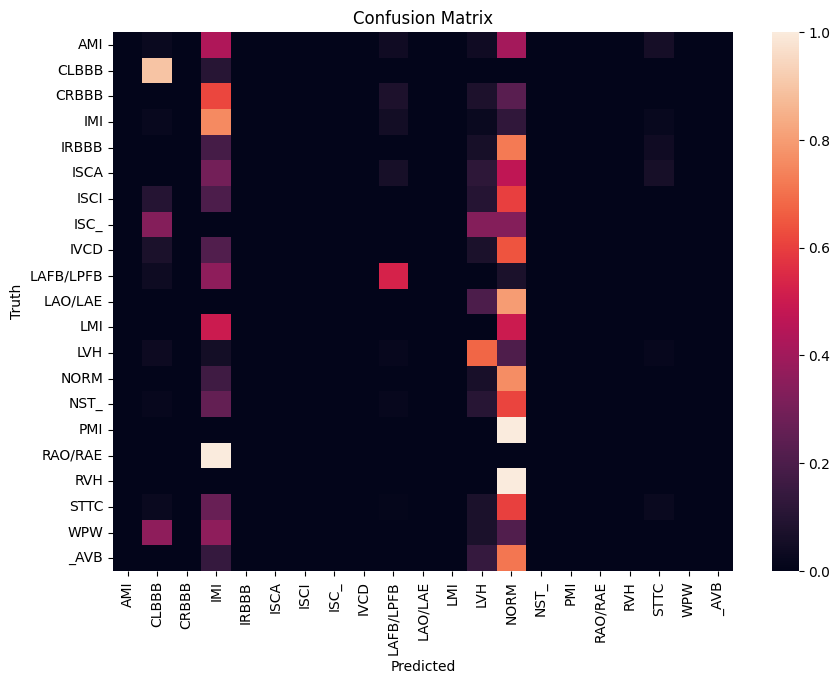

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_test_binary = np.argmax(y_test.values, axis=-1)
y_pred_binary = np.argmax(y_pred, axis=1)

# compute the confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_binary, normalize = 'true')

class_names = ['AMI', 'CLBBB', 'CRBBB', 'ILBBB', 'IMI', 'IRBBB', 'ISCA', 'ISCI', 'ISC_', 'IVCD', 'LAFB/LPFB', 'LAO/LAE', 'LMI', 'LVH', 'NORM', 'NST_', 'PMI', 'RAO/RAE', 'RVH', 'SEHYP', 'STTC', 'WPW', '_AVB']
class_dict = {i: name for i, name in enumerate(class_names)}

test_classes = np.unique(y_test_binary)
pred_classes = np.unique(y_pred_binary)
all_classes = np.union1d(test_classes, pred_classes)

target_names_matrix = [class_dict[i] for i in all_classes]


# use seaborn to create a heatmap visualization of the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, xticklabels=target_names_matrix, yticklabels=target_names_matrix)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


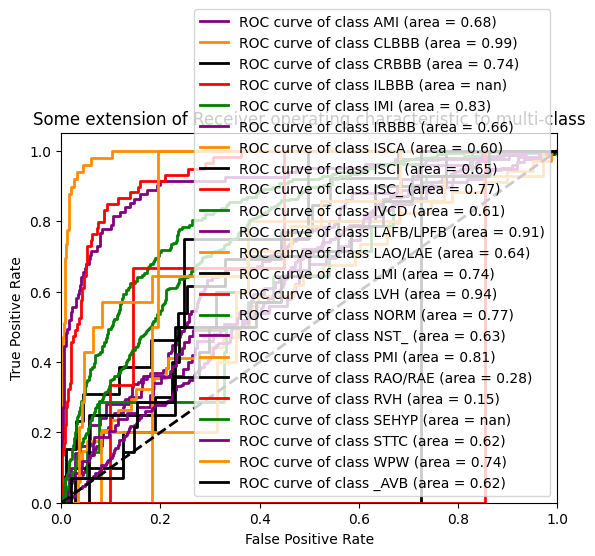

In [33]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt

y_test_array = y_test.values

n_classes = y_test.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_array[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Plot all ROC curvesplt.figure()
for i, color in zip(range(n_classes), cycle(['purple', 'darkorange', 'black', 'red', 'green'])):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(target_names[i], roc_auc[i]))  # replace 'i' with 'target_names[i]'

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# CNN


In [34]:
# Define the ECG branch of the model
ecg_input = layers.Input(shape=(1000, 12))
ecg_layer = layers.Conv1D(64, 7, activation='relu')(ecg_input)
ecg_layer = layers.MaxPooling1D(3)(ecg_layer)
ecg_layer = layers.Conv1D(64, 7, activation='relu')(ecg_layer)
ecg_layer = layers.MaxPooling1D(3)(ecg_layer)
ecg_layer = layers.Dropout(0.5)(ecg_layer)
ecg_layer = layers.Flatten()(ecg_layer)


# Add a couple of Dense layers
output = layers.Dense(64, activation='relu')(ecg_layer)
output = layers.Dropout(0.5)(output)
output = layers.Dense(y_train.shape[1], activation='softmax')(output)

# Build the model
model = tf.keras.Model(inputs=[ecg_input], outputs=output)


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1000, 12)]        0         
                                                                 
 conv1d_12 (Conv1D)          (None, 994, 64)           5440      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 331, 64)          0         
 1D)                                                             
                                                                 
 conv1d_13 (Conv1D)          (None, 325, 64)           28736     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 108, 64)          0         
 1D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 108, 64)           0   

In [35]:
print("Training data:", X_ecg_train.shape)
print("Validation data:", X_ecg_val.shape)
print("Test data:", X_ecg_test.shape)

#class_weight = {0: 0.3, 1: 1., 2: 0.3, 3: 0.15, 4: 0.3}
# Print the index and type of all non-array elements in X_ecg_train


history_12 = model.fit(
    X_ecg_train,
    y_train,
    validation_data=(X_ecg_val, y_val),
    epochs=20,  # specify the number of epochs
    batch_size=32,  # specify your batch size
    #class_weight = class_weight
)

Training data: (5747, 1000, 12)
Validation data: (1232, 1000, 12)
Test data: (1232, 1000, 12)
Epoch 1/20
180/180 [==============================] - 3s 8ms/step - loss: 2.3712 - categorical_accuracy: 0.2744 - val_loss: 1.9894 - val_categorical_accuracy: 0.4026
Epoch 2/20
180/180 [==============================] - 1s 5ms/step - loss: 1.8825 - categorical_accuracy: 0.4444 - val_loss: 1.6853 - val_categorical_accuracy: 0.4968
Epoch 3/20
180/180 [==============================] - 1s 5ms/step - loss: 1.6491 - categorical_accuracy: 0.5121 - val_loss: 1.5866 - val_categorical_accuracy: 0.5122
Epoch 4/20
180/180 [==============================] - 1s 5ms/step - loss: 1.4943 - categorical_accuracy: 0.5540 - val_loss: 1.4901 - val_categorical_accuracy: 0.5495
Epoch 5/20
180/180 [==============================] - 1s 5ms/step - loss: 1.3548 - categorical_accuracy: 0.5902 - val_loss: 1.4301 - val_categorical_accuracy: 0.5649
Epoch 6/20
180/180 [==============================] - 1s 5ms/step - loss: 1.

In [36]:
from sklearn.metrics import roc_auc_score, classification_report

# Ensure your data is correctly shaped. If your data preparation step is correct,
# X_ecg_test should already have the shape of (num_instances, 1000, 12).
# In case it doesn't, reshape it as necessary.

# Predict with the reshaped data
y_pred = model.predict(X_ecg_test)

# Convert the predictions from probabilities to binary outputs (0 and 1)
# This is necessary for multi-label classification
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# ROC AUC
roc_auc = roc_auc_score(y_test, y_pred, average='samples')  # Multi-label case
print(f'ROC AUC Score: {roc_auc}')

# Classification Report
target_names = ['AMI', 'CLBBB', 'CRBBB', 'ILBBB', 'IMI', 'IRBBB', 'ISCA', 'ISCI', 'ISC_', 'IVCD', 'LAFB/LPFB', 'LAO/LAE', 'LMI', 'LVH', 'NORM', 'NST_', 'PMI', 'RAO/RAE', 'RVH', 'SEHYP', 'STTC', 'WPW', '_AVB']
print(classification_report(y_test, y_pred_binary, target_names=target_names))


39/39 [==============================] - 0s 2ms/step
ROC AUC Score: 0.9428128689492326
              precision    recall  f1-score   support

         AMI       0.87      0.46      0.60       125
       CLBBB       1.00      0.98      0.99        49
       CRBBB       0.71      0.77      0.74        13
       ILBBB       0.00      0.00      0.00         0
         IMI       0.72      0.68      0.70       184
       IRBBB       0.64      0.42      0.51        50
        ISCA       0.50      0.03      0.06        34
        ISCI       0.00      0.00      0.00        10
        ISC_       0.00      0.00      0.00         3
        IVCD       0.00      0.00      0.00        14
   LAFB/LPFB       0.79      0.67      0.72        81
     LAO/LAE       0.00      0.00      0.00         5
         LMI       0.00      0.00      0.00         4
         LVH       0.59      0.37      0.46        59
        NORM       0.64      0.77      0.70       298
        NST_       0.14      0.02      0.03     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Test

In [37]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_ecg_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


39/39 [==============================] - 0s 3ms/step - loss: 1.6773 - categorical_accuracy: 0.6039
Test Loss: 1.6772969961166382
Test Accuracy: 0.6038960814476013


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


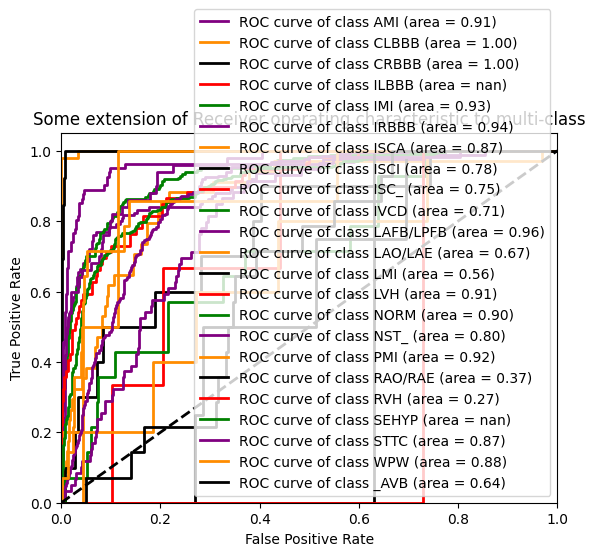

In [38]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt

y_test_array = y_test.values

n_classes = y_test.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_array[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Plot all ROC curvesplt.figure()
for i, color in zip(range(n_classes), cycle(['purple', 'darkorange', 'black', 'red', 'green'])):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(target_names[i], roc_auc[i]))  # replace 'i' with 'target_names[i]'

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


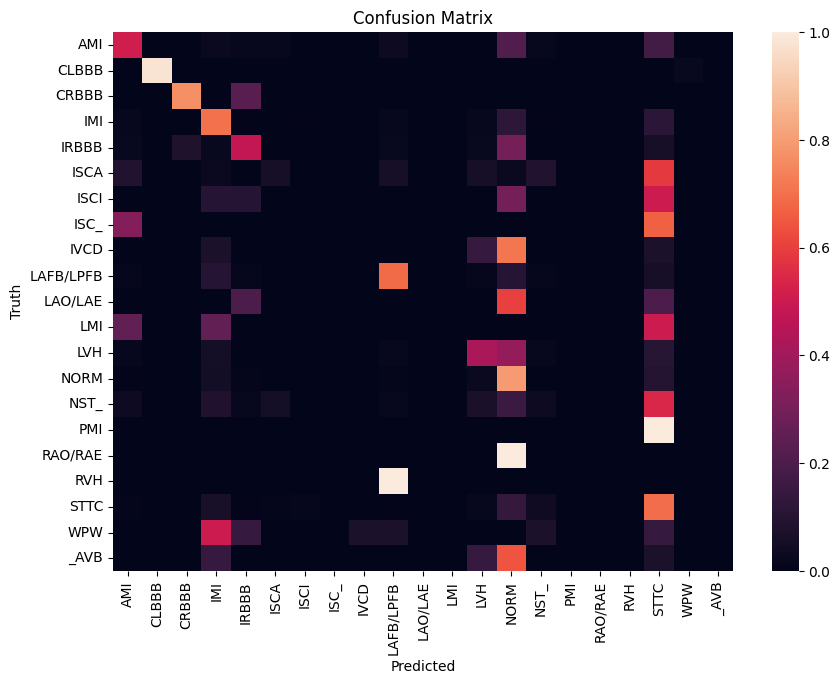

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_test_binary = np.argmax(y_test.values, axis=-1)
y_pred_binary = np.argmax(y_pred, axis=1)

# compute the confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_binary, normalize = 'true')

class_names = ['AMI', 'CLBBB', 'CRBBB', 'ILBBB', 'IMI', 'IRBBB', 'ISCA', 'ISCI', 'ISC_', 'IVCD', 'LAFB/LPFB', 'LAO/LAE', 'LMI', 'LVH', 'NORM', 'NST_', 'PMI', 'RAO/RAE', 'RVH', 'SEHYP', 'STTC', 'WPW', '_AVB']
class_dict = {i: name for i, name in enumerate(class_names)}

test_classes = np.unique(y_test_binary)
pred_classes = np.unique(y_pred_binary)
all_classes = np.union1d(test_classes, pred_classes)

target_names_matrix = [class_dict[i] for i in all_classes]


# use seaborn to create a heatmap visualization of the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm,xticklabels=target_names_matrix, yticklabels=target_names_matrix)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()


In [40]:
print(np.unique(y_test_binary))
print(np.unique(y_pred_binary))


[ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22]
[ 0  1  2  4  5  6  7  9 10 13 14 15 20 21]


## 10-Fold


In [41]:
# from sklearn.model_selection import KFold

# # Define the number of folds
# n_folds = 10
# kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# # Define your data
# X = np.array(df_cleaned['signal'].tolist())
# y = df_cleaned.drop(['record_name', 'signal', 'age', 'sex'], axis=1)

# scores = []

# for train_index, val_index in kfold.split(X):
#     X_train, X_val = X[train_index], X[val_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#     # Define the ECG branch of the model
#     ecg_input = layers.Input(shape=(2500, 12))
#     ecg_layer = layers.Conv1D(64, 7, activation='relu')(ecg_input)
#     ecg_layer = layers.MaxPooling1D(3)(ecg_layer)
#     ecg_layer = layers.Conv1D(64, 7, activation='relu')(ecg_layer)
#     ecg_layer = layers.MaxPooling1D(3)(ecg_layer)
#     ecg_layer = layers.Dropout(0.5)(ecg_layer)
#     ecg_layer = layers.Flatten()(ecg_layer)

#     # Add a couple of Dense layers
#     output = layers.Dense(64, activation='relu')(ecg_layer)
#     output = layers.Dropout(0.5)(output)
#     output = layers.Dense(y_train.shape[1], activation='softmax')(output)

#     # Build the model
#     model = tf.keras.Model(inputs=[ecg_input], outputs=output)

#     # Compile the model
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

#     # Fit the model
#     model.fit(X_train, y_train,
#         epochs=10,
#         #batch_size=32
#     )

#     # Evaluate the model
#     score = model.evaluate(X_val, y_val)
#     scores.append(score)

# # scores now contains your validation scores for each fold of the cross-validation
# # you can compute the average (and possibly standard deviation) of these scores to get a sense of how stable your model is across different folds

# # Convert the list of scores to a NumPy array
# # Note: if you used multiple metrics during model evaluation,
# # adjust indexing in the following lines accordingly
# scores = np.array(scores)

# # Calculate the mean and standard deviation of the scores
# mean_score = np.mean(scores[:, 1])  # Assuming accuracy is in the second position
# std_score = np.std(scores[:, 1])  # Assuming accuracy is in the second position

# # Print the mean and standard deviation
# print(f'Mean validation accuracy over {n_folds}-fold cross-validation: {mean_score * 100:.2f}%')
# print(f'Standard deviation: {std_score * 100:.2f}%')

# # Plot a histogram of the scores
# plt.hist(scores[:, 1], bins=10)  # Assuming accuracy is in the second position
# plt.title(f'Histogram of validation accuracy over {n_folds}-fold cross-validation')
# plt.xlabel('Validation Accuracy')
# plt.ylabel('Count')
# plt.show()


## 8 leads

In [42]:
df_cleaned = df_encoded
# Extract only the first three leads from every ECG signal
df_cleaned['signal'] = df_cleaned['signal'].apply(lambda signal: signal[:, :8])

# Define the ECG branch of the model
ecg_input = layers.Input(shape=(1000, 8))  # Adjust to match the number of leads
ecg_layer = layers.Conv1D(64, 7, activation='relu')(ecg_input)
ecg_layer = layers.MaxPooling1D(3)(ecg_layer)
ecg_layer = layers.Conv1D(64, 7, activation='relu')(ecg_layer)
ecg_layer = layers.MaxPooling1D(3)(ecg_layer)
ecg_layer = layers.Dropout(0.5)(ecg_layer)
ecg_layer = layers.Flatten()(ecg_layer)

# Add a couple of Dense layers
output = layers.Dense(64, activation='relu')(ecg_layer)
output = layers.Dropout(0.5)(output)
output = layers.Dense(y_train.shape[1], activation='softmax')(output)

# Build the model
model = tf.keras.Model(inputs=[ecg_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
model.summary()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_cleaned['signal'].tolist(), y, test_size=0.2, random_state=1)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)  # 0.25 x 0.8 = 0.2

# Convert the lists to numpy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

# Fit the model
history_8 = model.fit([X_train], y_train, epochs=20, validation_data=([X_val], y_val))

test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1000, 8)]         0         
                                                                 
 conv1d_14 (Conv1D)          (None, 994, 64)           3648      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 331, 64)          0         
 1D)                                                             
                                                                 
 conv1d_15 (Conv1D)          (None, 325, 64)           28736     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 108, 64)          0         
 1D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 108, 64)           0   

52/52 [==============================] - 0s 2ms/step
ROC AUC Score: 0.9402423504675483
              precision    recall  f1-score   support

         AMI       0.68      0.54      0.60       148
       CLBBB       0.93      0.97      0.95        72
       CRBBB       0.86      0.95      0.90        19
       ILBBB       0.00      0.00      0.00         0
         IMI       0.57      0.77      0.66       257
       IRBBB       0.71      0.27      0.39        55
        ISCA       0.00      0.00      0.00        43
        ISCI       0.00      0.00      0.00        26
        ISC_       0.00      0.00      0.00         3
        IVCD       0.00      0.00      0.00        22
   LAFB/LPFB       0.72      0.83      0.77        88
     LAO/LAE       0.00      0.00      0.00         4
         LMI       0.00      0.00      0.00         9
         LVH       0.24      0.05      0.08        81
        NORM       0.63      0.69      0.66       421
        NST_       0.31      0.06      0.10     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


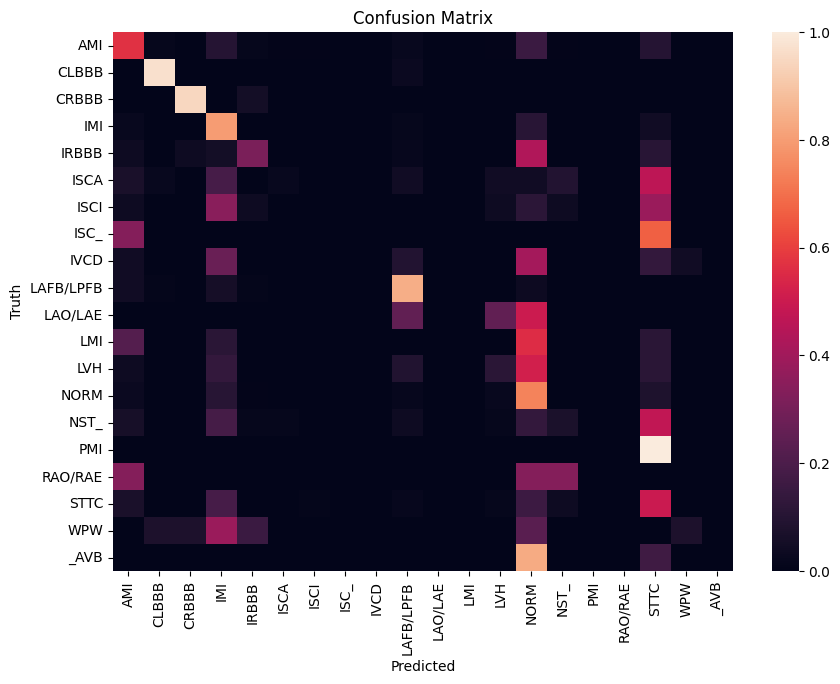

In [43]:
from sklearn.metrics import roc_auc_score, classification_report

# Ensure your data is correctly shaped. If your data preparation step is correct,
# X_ecg_test should already have the shape of (num_instances, 1000, 12).
# In case it doesn't, reshape it as necessary.

# Predict with the reshaped data
y_pred = model.predict(X_test)

# Convert the predictions from probabilities to binary outputs (0 and 1)
# This is necessary for multi-label classification
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# ROC AUC
roc_auc = roc_auc_score(y_test, y_pred, average='samples')  # Multi-label case
print(f'ROC AUC Score: {roc_auc}')

# Classification Report
target_names = ['AMI', 'CLBBB', 'CRBBB', 'ILBBB', 'IMI', 'IRBBB', 'ISCA', 'ISCI', 'ISC_', 'IVCD', 'LAFB/LPFB', 'LAO/LAE', 'LMI', 'LVH', 'NORM', 'NST_', 'PMI', 'RAO/RAE', 'RVH', 'SEHYP', 'STTC', 'WPW', '_AVB']
print(classification_report(y_test, y_pred_binary, target_names=target_names))
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_test_binary = np.argmax(y_test.values, axis=-1)
y_pred_binary = np.argmax(y_pred, axis=1)

# compute the confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_binary, normalize = 'true')

class_names = ['AMI', 'CLBBB', 'CRBBB', 'ILBBB', 'IMI', 'IRBBB', 'ISCA', 'ISCI', 'ISC_', 'IVCD', 'LAFB/LPFB', 'LAO/LAE', 'LMI', 'LVH', 'NORM', 'NST_', 'PMI', 'RAO/RAE', 'RVH', 'SEHYP', 'STTC', 'WPW', '_AVB']
class_dict = {i: name for i, name in enumerate(class_names)}

test_classes = np.unique(y_test_binary)
pred_classes = np.unique(y_pred_binary)
all_classes = np.union1d(test_classes, pred_classes)

target_names_matrix = [class_dict[i] for i in all_classes]


# use seaborn to create a heatmap visualization of the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, xticklabels=target_names_matrix, yticklabels=target_names_matrix)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()


## 4 leads

In [44]:
# Extract only the first three leads from every ECG signal
df_cleaned['signal'] = df_cleaned['signal'].apply(lambda signal: signal[:, :4])

# Define the ECG branch of the model
ecg_input = layers.Input(shape=(1000, 4))  # Adjust to match the number of leads
ecg_layer = layers.Conv1D(64, 7, activation='relu')(ecg_input)
ecg_layer = layers.MaxPooling1D(3)(ecg_layer)
ecg_layer = layers.Conv1D(64, 7, activation='relu')(ecg_layer)
ecg_layer = layers.MaxPooling1D(3)(ecg_layer)
ecg_layer = layers.Dropout(0.5)(ecg_layer)
ecg_layer = layers.Flatten()(ecg_layer)

# Add a couple of Dense layers
output = layers.Dense(64, activation='relu')(ecg_layer)
output = layers.Dropout(0.5)(output)
output = layers.Dense(y_train.shape[1], activation='softmax')(output)

# Build the model
model = tf.keras.Model(inputs=[ecg_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
model.summary()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_cleaned['signal'].tolist(), y, test_size=0.2, random_state=1)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)  # 0.25 x 0.8 = 0.2

# Convert the lists to numpy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

# Fit the model
history_4 = model.fit([X_train], y_train, epochs=20, validation_data=([X_val], y_val))

test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1000, 4)]         0         
                                                                 
 conv1d_16 (Conv1D)          (None, 994, 64)           1856      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 331, 64)          0         
 1D)                                                             
                                                                 
 conv1d_17 (Conv1D)          (None, 325, 64)           28736     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 108, 64)          0         
 1D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 108, 64)           0   

52/52 [==============================] - 0s 2ms/step
ROC AUC Score: 0.9243069772588945
              precision    recall  f1-score   support

         AMI       0.20      0.03      0.06       148
       CLBBB       0.93      0.88      0.90        72
       CRBBB       0.83      0.26      0.40        19
       ILBBB       0.00      0.00      0.00         0
         IMI       0.71      0.65      0.68       257
       IRBBB       0.42      0.09      0.15        55
        ISCA       1.00      0.02      0.05        43
        ISCI       0.00      0.00      0.00        26
        ISC_       0.00      0.00      0.00         3
        IVCD       0.00      0.00      0.00        22
   LAFB/LPFB       0.69      0.75      0.72        88
     LAO/LAE       0.00      0.00      0.00         4
         LMI       0.00      0.00      0.00         9
         LVH       0.56      0.12      0.20        81
        NORM       0.55      0.75      0.63       421
        NST_       0.14      0.02      0.04     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


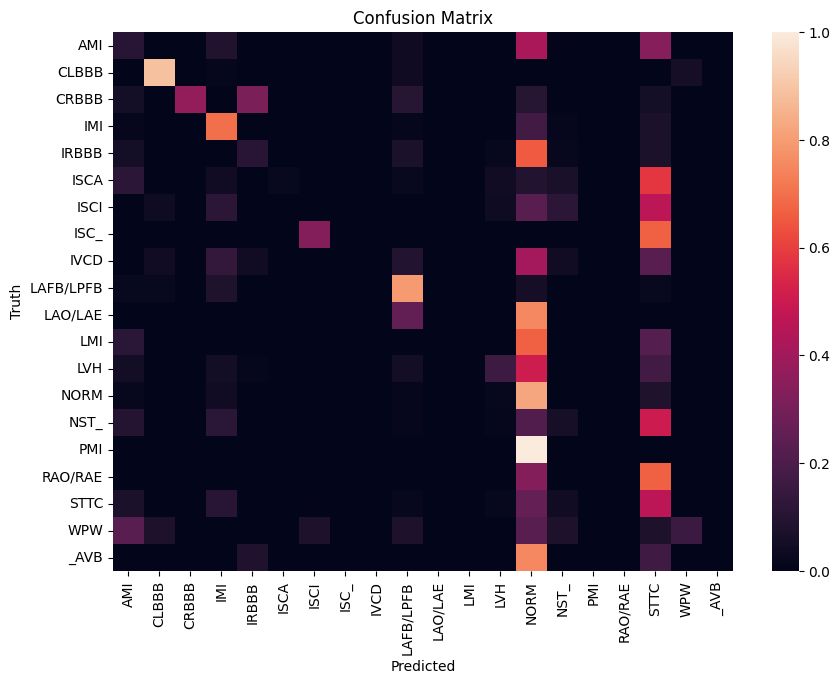

In [45]:
from sklearn.metrics import roc_auc_score, classification_report

# Ensure your data is correctly shaped. If your data preparation step is correct,
# X_ecg_test should already have the shape of (num_instances, 1000, 12).
# In case it doesn't, reshape it as necessary.

# Predict with the reshaped data
y_pred = model.predict(X_test)

# Convert the predictions from probabilities to binary outputs (0 and 1)
# This is necessary for multi-label classification
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# ROC AUC
roc_auc = roc_auc_score(y_test, y_pred, average='samples')  # Multi-label case
print(f'ROC AUC Score: {roc_auc}')

# Classification Report
target_names = ['AMI', 'CLBBB', 'CRBBB', 'ILBBB', 'IMI', 'IRBBB', 'ISCA', 'ISCI', 'ISC_', 'IVCD', 'LAFB/LPFB', 'LAO/LAE', 'LMI', 'LVH', 'NORM', 'NST_', 'PMI', 'RAO/RAE', 'RVH', 'SEHYP', 'STTC', 'WPW', '_AVB']
print(classification_report(y_test, y_pred_binary, target_names=target_names))
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_test_binary = np.argmax(y_test.values, axis=-1)
y_pred_binary = np.argmax(y_pred, axis=1)

# compute the confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_binary, normalize = 'true')

class_names = ['AMI', 'CLBBB', 'CRBBB', 'ILBBB', 'IMI', 'IRBBB', 'ISCA', 'ISCI', 'ISC_', 'IVCD', 'LAFB/LPFB', 'LAO/LAE', 'LMI', 'LVH', 'NORM', 'NST_', 'PMI', 'RAO/RAE', 'RVH', 'SEHYP', 'STTC', 'WPW', '_AVB']
class_dict = {i: name for i, name in enumerate(class_names)}

test_classes = np.unique(y_test_binary)
pred_classes = np.unique(y_pred_binary)
all_classes = np.union1d(test_classes, pred_classes)

target_names_matrix = [class_dict[i] for i in all_classes]


# use seaborn to create a heatmap visualization of the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, xticklabels=target_names_matrix, yticklabels=target_names_matrix)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()


## 2 lead (II)

In [46]:
df_cleaned['signal'] = df_cleaned['signal'].apply(lambda signal: signal[:, :2])

# Define the ECG branch of the model
ecg_input = layers.Input(shape=(1000, 2))  # Adjust to match the number of leads
ecg_layer = layers.Conv1D(64, 7, activation='relu')(ecg_input)
ecg_layer = layers.MaxPooling1D(3)(ecg_layer)
ecg_layer = layers.Conv1D(64, 7, activation='relu')(ecg_layer)
ecg_layer = layers.MaxPooling1D(3)(ecg_layer)
ecg_layer = layers.Dropout(0.5)(ecg_layer)
ecg_layer = layers.Flatten()(ecg_layer)

# Add a couple of Dense layers
output = layers.Dense(64, activation='relu')(ecg_layer)
output = layers.Dropout(0.5)(output)
output = layers.Dense(y_train.shape[1], activation='softmax')(output)

# Build the model
model = tf.keras.Model(inputs=[ecg_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
model.summary()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_cleaned['signal'].tolist(), y, test_size=0.2, random_state=1)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)  # 0.25 x 0.8 = 0.2

# Convert the lists to numpy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

# Fit the model
history_2 = model.fit([X_train], y_train, epochs=20, validation_data=([X_val], y_val))

test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1000, 2)]         0         
                                                                 
 conv1d_18 (Conv1D)          (None, 994, 64)           960       
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 331, 64)          0         
 1D)                                                             
                                                                 
 conv1d_19 (Conv1D)          (None, 325, 64)           28736     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 108, 64)          0         
 1D)                                                             
                                                                 
 dropout_11 (Dropout)        (None, 108, 64)           0   

52/52 [==============================] - 0s 2ms/step
ROC AUC Score: 0.9286504730813921
              precision    recall  f1-score   support

         AMI       0.29      0.05      0.08       148
       CLBBB       0.91      0.94      0.93        72
       CRBBB       1.00      0.11      0.19        19
       ILBBB       0.00      0.00      0.00         0
         IMI       0.78      0.60      0.67       257
       IRBBB       0.60      0.05      0.10        55
        ISCA       0.00      0.00      0.00        43
        ISCI       0.00      0.00      0.00        26
        ISC_       0.00      0.00      0.00         3
        IVCD       0.00      0.00      0.00        22
   LAFB/LPFB       0.66      0.81      0.73        88
     LAO/LAE       0.00      0.00      0.00         4
         LMI       0.00      0.00      0.00         9
         LVH       0.48      0.19      0.27        81
        NORM       0.56      0.77      0.65       421
        NST_       0.25      0.01      0.02     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


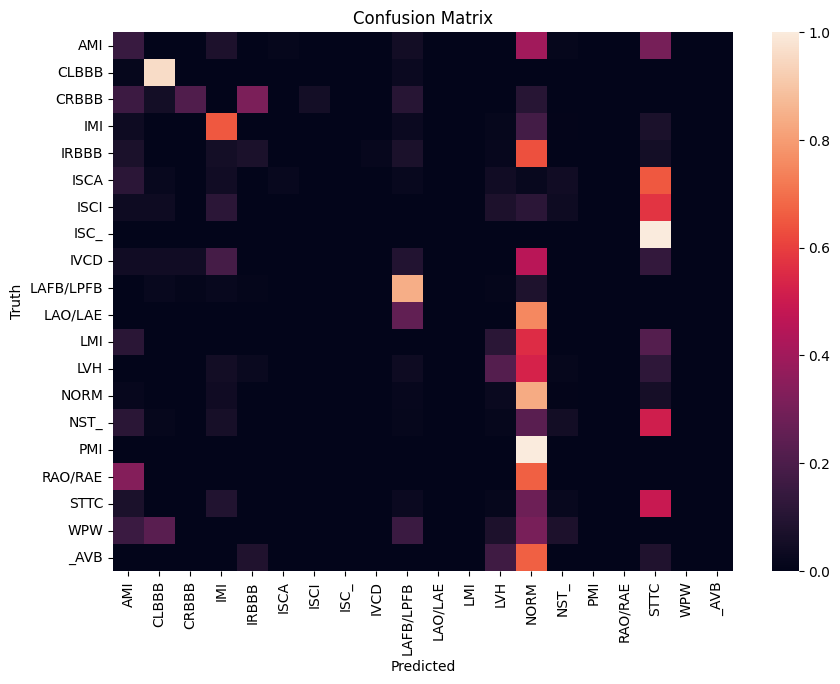

In [47]:
from sklearn.metrics import roc_auc_score, classification_report

# Ensure your data is correctly shaped. If your data preparation step is correct,
# X_ecg_test should already have the shape of (num_instances, 1000, 12).
# In case it doesn't, reshape it as necessary.

# Predict with the reshaped data
y_pred = model.predict(X_test)

# Convert the predictions from probabilities to binary outputs (0 and 1)
# This is necessary for multi-label classification
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# ROC AUC
roc_auc = roc_auc_score(y_test, y_pred, average='samples')  # Multi-label case
print(f'ROC AUC Score: {roc_auc}')

# Classification Report
target_names = ['AMI', 'CLBBB', 'CRBBB', 'ILBBB', 'IMI', 'IRBBB', 'ISCA', 'ISCI', 'ISC_', 'IVCD', 'LAFB/LPFB', 'LAO/LAE', 'LMI', 'LVH', 'NORM', 'NST_', 'PMI', 'RAO/RAE', 'RVH', 'SEHYP', 'STTC', 'WPW', '_AVB']
print(classification_report(y_test, y_pred_binary, target_names=target_names))
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_test_binary = np.argmax(y_test.values, axis=-1)
y_pred_binary = np.argmax(y_pred, axis=1)

# compute the confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_binary, normalize = 'true')

class_names = ['AMI', 'CLBBB', 'CRBBB', 'ILBBB', 'IMI', 'IRBBB', 'ISCA', 'ISCI', 'ISC_', 'IVCD', 'LAFB/LPFB', 'LAO/LAE', 'LMI', 'LVH', 'NORM', 'NST_', 'PMI', 'RAO/RAE', 'RVH', 'SEHYP', 'STTC', 'WPW', '_AVB']
class_dict = {i: name for i, name in enumerate(class_names)}

test_classes = np.unique(y_test_binary)
pred_classes = np.unique(y_pred_binary)
all_classes = np.union1d(test_classes, pred_classes)

target_names_matrix = [class_dict[i] for i in all_classes]


# use seaborn to create a heatmap visualization of the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, xticklabels=target_names_matrix, yticklabels=target_names_matrix)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()


## 1 lead (II)

In [48]:
# Extract only the first three leads from every ECG signal
df_cleaned['signal'] = df_cleaned['signal'].apply(lambda signal: signal[:, :1])

# Define the ECG branch of the model
ecg_input = layers.Input(shape=(1000, 1))  # Adjust to match the number of leads
ecg_layer = layers.Conv1D(64, 7, activation='relu')(ecg_input)
ecg_layer = layers.MaxPooling1D(3)(ecg_layer)
ecg_layer = layers.Conv1D(64, 7, activation='relu')(ecg_layer)
ecg_layer = layers.MaxPooling1D(3)(ecg_layer)
ecg_layer = layers.Dropout(0.5)(ecg_layer)
ecg_layer = layers.Flatten()(ecg_layer)

# Add a couple of Dense layers
output = layers.Dense(64, activation='relu')(ecg_layer)
output = layers.Dropout(0.5)(output)
output = layers.Dense(y_train.shape[1], activation='softmax')(output)

# Build the model
model = tf.keras.Model(inputs=[ecg_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
model.summary()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_cleaned['signal'].tolist(), y, test_size=0.2, random_state=1)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)  # 0.25 x 0.8 = 0.2

# Convert the lists to numpy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

# Fit the model
history_1 = model.fit([X_train], y_train, epochs=20, validation_data=([X_val], y_val))

test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 1000, 1)]         0         
                                                                 
 conv1d_20 (Conv1D)          (None, 994, 64)           512       
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 331, 64)          0         
 1D)                                                             
                                                                 
 conv1d_21 (Conv1D)          (None, 325, 64)           28736     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 108, 64)          0         
 g1D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 108, 64)           0   

52/52 [==============================] - 0s 1ms/step
ROC AUC Score: 0.8959774248879544
              precision    recall  f1-score   support

         AMI       0.57      0.03      0.05       148
       CLBBB       0.85      0.94      0.89        72
       CRBBB       0.84      0.84      0.84        19
       ILBBB       0.00      0.00      0.00         0
         IMI       0.24      0.07      0.10       257
       IRBBB       0.50      0.09      0.15        55
        ISCA       0.00      0.00      0.00        43
        ISCI       0.00      0.00      0.00        26
        ISC_       0.00      0.00      0.00         3
        IVCD       0.00      0.00      0.00        22
   LAFB/LPFB       0.50      0.02      0.04        88
     LAO/LAE       0.00      0.00      0.00         4
         LMI       0.00      0.00      0.00         9
         LVH       0.39      0.09      0.14        81
        NORM       0.50      0.48      0.49       421
        NST_       0.50      0.01      0.02     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


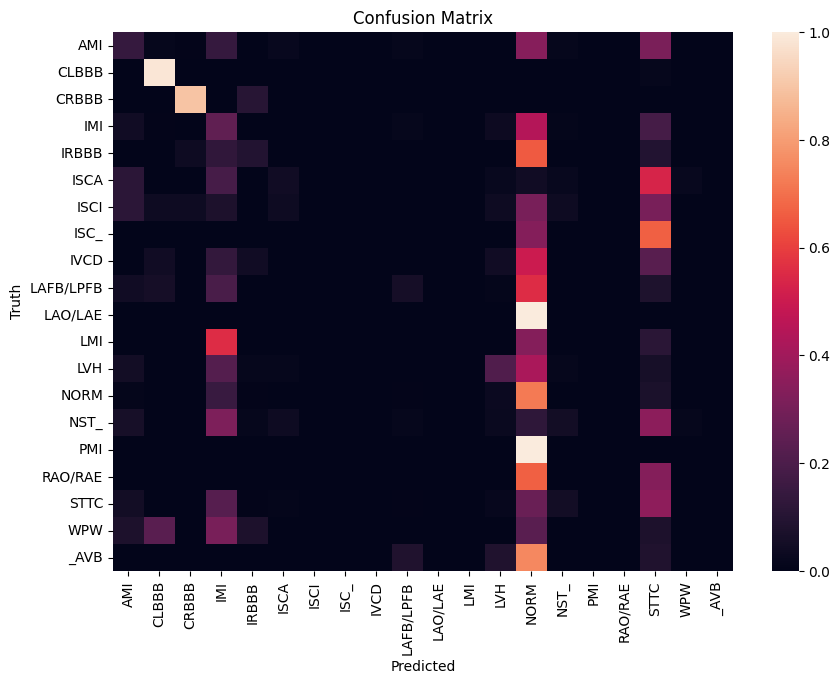

In [49]:
from sklearn.metrics import roc_auc_score, classification_report

# Ensure your data is correctly shaped. If your data preparation step is correct,
# X_ecg_test should already have the shape of (num_instances, 1000, 12).
# In case it doesn't, reshape it as necessary.

# Predict with the reshaped data
y_pred = model.predict(X_test)

# Convert the predictions from probabilities to binary outputs (0 and 1)
# This is necessary for multi-label classification
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# ROC AUC
roc_auc = roc_auc_score(y_test, y_pred, average='samples')  # Multi-label case
print(f'ROC AUC Score: {roc_auc}')

# Classification Report
target_names = ['AMI', 'CLBBB', 'CRBBB', 'ILBBB', 'IMI', 'IRBBB', 'ISCA', 'ISCI', 'ISC_', 'IVCD', 'LAFB/LPFB', 'LAO/LAE', 'LMI', 'LVH', 'NORM', 'NST_', 'PMI', 'RAO/RAE', 'RVH', 'SEHYP', 'STTC', 'WPW', '_AVB']
print(classification_report(y_test, y_pred_binary, target_names=target_names))
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_test_binary = np.argmax(y_test.values, axis=-1)
y_pred_binary = np.argmax(y_pred, axis=1)

# compute the confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_binary, normalize = 'true')

class_names = ['AMI', 'CLBBB', 'CRBBB', 'ILBBB', 'IMI', 'IRBBB', 'ISCA', 'ISCI', 'ISC_', 'IVCD', 'LAFB/LPFB', 'LAO/LAE', 'LMI', 'LVH', 'NORM', 'NST_', 'PMI', 'RAO/RAE', 'RVH', 'SEHYP', 'STTC', 'WPW', '_AVB']
class_dict = {i: name for i, name in enumerate(class_names)}

test_classes = np.unique(y_test_binary)
pred_classes = np.unique(y_pred_binary)
all_classes = np.union1d(test_classes, pred_classes)

target_names_matrix = [class_dict[i] for i in all_classes]


# use seaborn to create a heatmap visualization of the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, xticklabels=target_names_matrix, yticklabels=target_names_matrix)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()


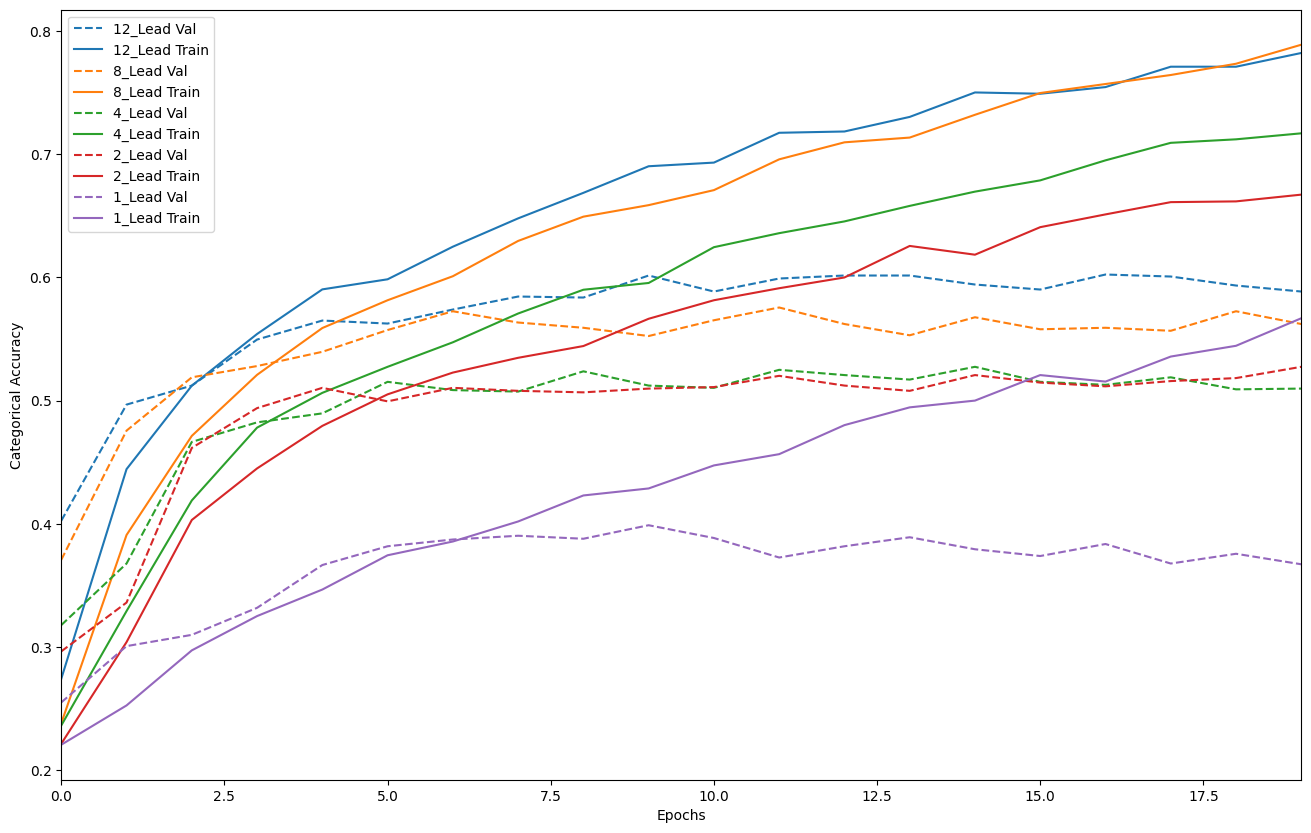

In [50]:
def plot_history(histories, key='categorical_accuracy'):
    plt.figure(figsize=(16,10))
    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                       '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                 label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])

# Assuming `history1`, `history2`, `history3`, `history4` are your histories of your models
plot_history([('12_lead', history_12),
              ('8_lead', history_8),
              ('4_lead', history_4),
              ('2_lead', history_2),
              ('1_lead', history_1)])


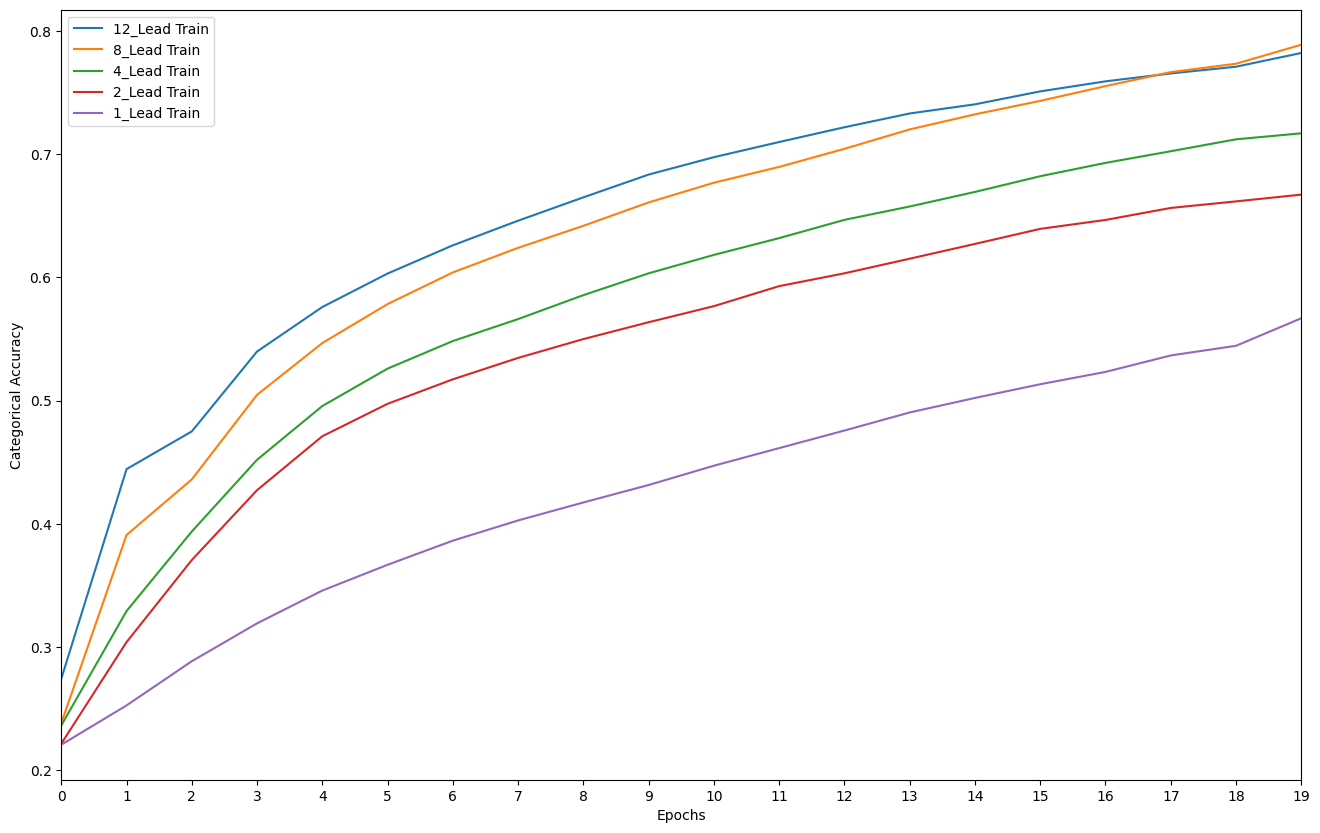

In [51]:
def plot_smooth_history(histories, key='categorical_accuracy', window=5):
    plt.figure(figsize=(16,10))

    for name, history in histories:
        val = pd.Series(history.history[key])
        val_smooth = val.rolling(window=window, center=True).mean().fillna(val)
        plt.plot(val_smooth, label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    # Find the maximum epoch for the x-axis limit
    max_epoch = max([max(history.epoch) for _, history in histories])
    plt.xlim([0, max_epoch])

    # Set the x-axis ticks to integers
    plt.xticks(np.arange(0, max_epoch+1, step=1))

# Assuming `history1`, `history2`, `history3`, `history4` are your histories of your models
plot_smooth_history([('12_lead', history_12),
                     ('8_lead', history_8),
                     ('4_lead', history_4),
                     ('2_lead', history_2),
                     ('1_lead', history_1)])


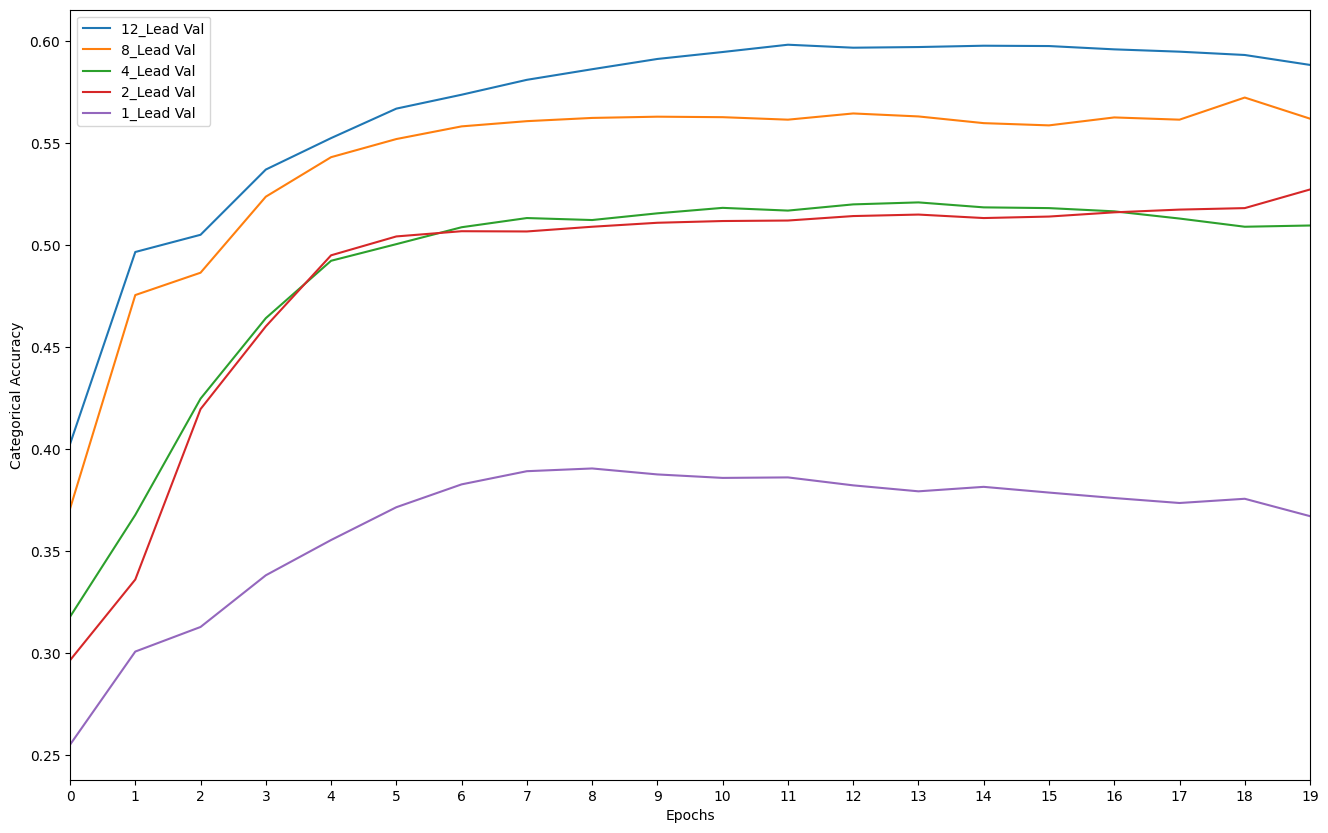

In [52]:
def plot_smooth_history(histories, key='categorical_accuracy', window=5):
    plt.figure(figsize=(16,10))

    for name, history in histories:
        val = pd.Series(history.history['val_'+key])
        val_smooth = val.rolling(window=window, center=True).mean().fillna(val)
        plt.plot(val_smooth, label=name.title()+' Val')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    # Find the maximum epoch for the x-axis limit
    max_epoch = max([max(history.epoch) for _, history in histories])
    plt.xlim([0, max_epoch])

    # Set the x-axis ticks to integers
    plt.xticks(np.arange(0, max_epoch+1, step=1))

# Assuming `history1`, `history2`, `history3`, `history4` are your histories of your models
plot_smooth_history([('12_lead', history_12),
                     ('8_lead', history_8),
                     ('4_lead', history_4),
                     ('2_lead', history_2),
                     ('1_lead', history_1)])


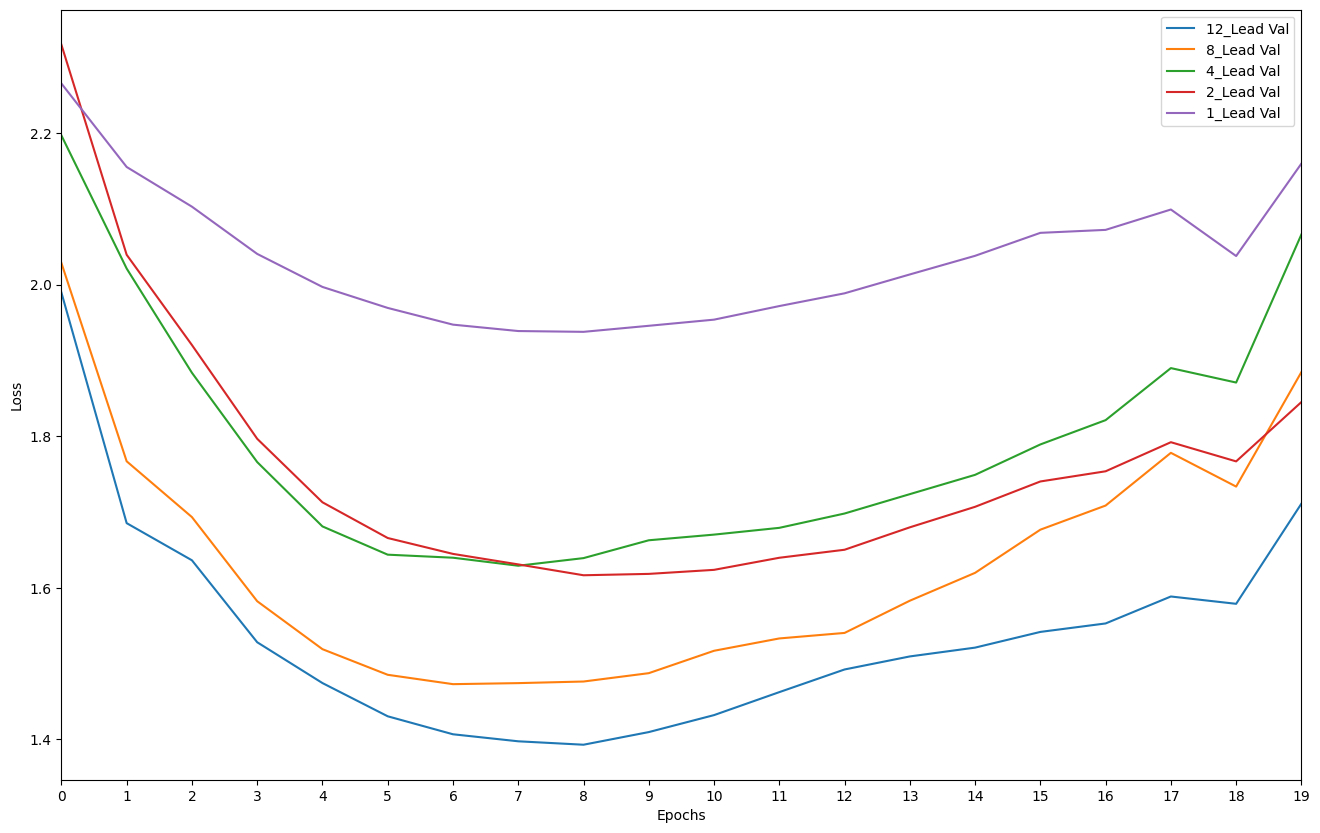

In [53]:
def plot_smooth_loss(histories, key='loss', window=5):
    plt.figure(figsize=(16,10))

    for name, history in histories:
        val = pd.Series(history.history['val_'+key])
        val_smooth = val.rolling(window=window, center=True).mean().fillna(val)
        plt.plot(val_smooth, label=name.title()+' Val')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    # Find the maximum epoch for the x-axis limit
    max_epoch = max([max(history.epoch) for _, history in histories])
    plt.xlim([0, max_epoch])

    # Set the x-axis ticks to integers
    plt.xticks(np.arange(0, max_epoch+1, step=1))

# Assuming `history1`, `history2`, `history3`, `history4` are your histories of your models
plot_smooth_loss([('12_lead', history_12),
                  ('8_lead', history_8),
                  ('4_lead', history_4),
                  ('2_lead', history_2),
                  ('1_lead', history_1)])


todo:
 - complete preprocessing -> normalization, Noise Reduction, Outlier Removal,Data Augmentation,downsampling, invert?
 - convert signal to spectogram 2D? (not 1D CNN raw data anymore, can be generated with STFT, 2D CNN) 1D simpler but 2D may perform better
 - remove diseases because accuracy is poor
 - rajouter age et sexe?
 - CNN prep, build, model train, evaluate
 - RNN
 - Transofrmer

- checker la normalisation
- passer en 250 sample rate

Done:
- remove last beat (when 0 volt)